# Recipe Classification with NLP

## Business Problem  
Man cannot live on Seamless alone but after a long day at work they may want to try.  Going to the internet for a recipe idea can be overwhelming, especially if you aren't a practiced cook. I hope to make cooking an easier option for people to choose by creating a model that will, when given a recipe, determine if it is an easy to prepare dinner or not. 

The practical applications of this model apply to more then just home chefs and it has more then one target audience:

- as mentioned home cooks could use this to check if a recipe fits their energy level and schedule, possibly by creating a web interface.
- websites that host recipes, or companies with collections of recipes - for example a publisher - could use this to auto-classify their recipes, which in turn could be used for SEO, for general organizational purposes, or for automating their review process.

The Nielsen rating service conducted a study in 2014 that found that 86 million Americans had visited recipies website that year, a number that has surely grown with Covid keeping more people at home. This audience, many of whom did not cook much before the virus struck, are ripe for guidance towards simple, week-night, dinners be it via website or cookbook. 

## Data Understanding  

The data used to build my model comes from KAGGLE LINK and consists of ~500,000 user-submitted recipes scraped from Food.com.  In addition to the text of the recipes' description and instructions the dataset also contains columns breaking out the ingredients, search terms, tags, and individual steps for each recipe. The tag data comes from the recipe author from a list of options provided by Food.com whereas the search terms are, from all evidence, assigned by Food.com. There is also an "id" column that can be used to search for the recipe on Food.com.

This dataset does not have a target variable included so one needs to be constructed for it by leveraging the tag and search term data to find dinner recipes that can be called easy, be it because they're quick, simple to make, or have very few steps. 

## Preliminary Data Cleaning   

The primary challenge in cleaning the dataset lay in the fact that a number of columns have string data that appears to be in list format:  
- "['apple', 'orange']"  
    vs.
- ['apple', 'orange'] 

Having this information in actual list format was a priority as it greatly simplified the EDA phase. 

This being said the overall dataset required very little cleaning - the information in each column was formated consistently and there were very few null values or other missing data. 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


from wordcloud import WordCloud
import ast # used for converting column values to lists post-import from csv

from nltk import FreqDist

pd.set_option("display.max_columns", None)


In [5]:
df = pd.read_csv('../data/foodcom_recipes_with_classification.csv')
df.head()

,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms
0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low..."
1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}"
2,41090,black-and-white bean salad,NaN,"['white beans', 'canned black beans', 'tomatoe...","[""1 cup canned white beans, rinsed and dra...",1 (807 g),1,"['In a large bowl, combine beans, tomato, onio...","['15-minutes-or-less', 'time-to-make', 'course...","{'vegetarian', 'salad', 'side', 'dinner', 'veg..."
3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}"
4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'}


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494963 entries, 0 to 494962
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   494963 non-null  int64 
 1   name                 494963 non-null  object
 2   description          485365 non-null  object
 3   ingredients          494963 non-null  object
 4   ingredients_raw_str  494963 non-null  object
 5   serving_size         494963 non-null  object
 6   servings             494963 non-null  int64 
 7   steps                494963 non-null  object
 8   tags                 494963 non-null  object
 9   search_terms         494963 non-null  object
dtypes: int64(2), object(8)
memory usage: 37.8+ MB


I chose to simply remove the null values in the "description" column; while this removes ~9,600 rows, or just under 2%, of data the overall scale of the dataset can support the loss.

In [7]:
# confirm number of null values in 'description'
df['description'].isna().sum()

9598

In [8]:
# drop columns with nulls
df = df.dropna(subset=['description'])

In [9]:
df['description'].value_counts()



.                                                                                                                                                                                                                                                                                                                                                                                                                                                                           439
yum                                                                                                                                                                                                                                                                                                                                                                                                                                                                         233
Rachael Ray                                                             

In [10]:
# recipes using '.' as the descriiption appear to be unique and so I will not be dropping these
# from the model 
df_period = df[df['description'] =='.']
df_period.head()

,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms
1158,488144,Mexican Wedding Cookies (Polvorones),.,['crisco%26reg%3b butter flavor all-vegetable ...,"[""1 cup Crisco\u0026reg; Butter Flavor Al...",1 (940 g),1,"['HEAT oven to 350°F.', 'COMBINE shortening, 1...","['60-minutes-or-less', 'time-to-make', 'course...","{'cookie', 'dessert', 'low-sodium', 'mexican'}"
2814,488146,Peppermint Cookies,.,['crisco%26reg%3b baking sticks butter flavor ...,"[""3/4 stick Crisco\u0026reg; Baking Sticks...",1 (639 g),1,"['HEAT oven to 350ºF.', 'BEAT shortening, brow...","['60-minutes-or-less', 'time-to-make', 'course...","{'cookie', 'dessert'}"
2963,494826,Teriyaki Chicken Fajitas,.,"['canola oil', 'mixed peppers', 'gold%27n plum...","[""2 tablespoons canola oil"",""1 (14 ounc...",1 (106 g),4,['Heat 1 tablespoon oil in a large skillet ove...,"['30-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'chicken'}"
4637,505389,Stovetop Green Bean Casserole,.,"['green beans', 'unsalted butter', 'all-purpos...","[""3 (12 ounce) bags trimmed steam-in-the-ba...",1 (135 g),12,['Microwave the green beans according to the p...,"['15-minutes-or-less', 'time-to-make', 'course...","{'low-calorie', 'low-sodium', 'side', 'cassero..."
7208,519452,Ranch Mac 'n Cheese,.,"['unseasoned breadcrumbs', 'evaporated milk', ...","[""1/2 cup unseasoned breadcrumbs"",""1 (5 ...",1 (150 g),6,"['Preheat oven to 350°F.', 'Cook pasta accordi...","['30-minutes-or-less', 'time-to-make', 'course...",{'dinner'}


In [11]:
# confirming nulls removed 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485365 entries, 0 to 494962
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   485365 non-null  int64 
 1   name                 485365 non-null  object
 2   description          485365 non-null  object
 3   ingredients          485365 non-null  object
 4   ingredients_raw_str  485365 non-null  object
 5   serving_size         485365 non-null  object
 6   servings             485365 non-null  int64 
 7   steps                485365 non-null  object
 8   tags                 485365 non-null  object
 9   search_terms         485365 non-null  object
dtypes: int64(2), object(8)
memory usage: 40.7+ MB


In [12]:
# reviewing other columns to see what other steps need to be taken
df.describe(include = 'object')


,name,description,ingredients,ingredients_raw_str,serving_size,steps,tags,search_terms
count,485365,485365,485365,485365,485365,485365,485365,485365
unique,406149,466949,480460,484299,5263,483643,409558,53505
top,Banana Bread,.,"['paper', 'cloth']","[""1 paper, serviette (large)"",""1 ...",1 (134 g),['Blend all ingredients until smooth.'],"['60-minutes-or-less', 'time-to-make', 'prepar...",{'dessert'}
freq,182,439,63,61,1416,32,625,23008


Reviewing the above several things stand out, such as the fact that Banana Bread is a very popular recipe, or that there are at least 63 recipes whose ingredients consist of 'paper' and 'cloth'.  Also noteworthy is that at least 32 recipes seem to be duplicates based on the 'steps' output.  Since neither paper or cloth are edible I removed those from the dataset and further investigated the 'steps' column to see if the recipes truly were duplicates - "Blend all ingredients until smooth" could apply to many different smoothie or milkshake recipies after all.

In [13]:
df_inedible = df[df['ingredients'] == "['paper', 'cloth']"]
df_inedible.head()

,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms
729,245565,"Serviette/Napkin Folding, Fleur De Lis in a Gl...","Between the teachings of my Grandmother, an Au...","['paper', 'cloth']","[""1 paper, serviette (large)"",""1 ...",1 (0 g),2,['Lay your serviette flat before you in a diam...,"['15-minutes-or-less', 'time-to-make', 'prepar...",{'dinner'}
2674,246865,"Serviette/Napkin Folding, Elegant Basic Roll V...",My interest in serviette folding was born on a...,"['paper', 'cloth']","[""1 paper, serviette (large)"",""1 ...",1 (0 g),2,['Lay your serviette square out flat before yo...,"['15-minutes-or-less', 'time-to-make', 'prepar...",{'dinner'}
4207,249824,"Serviette/Napkin, Elegant Place Mat",My interest in serviette folding was born on a...,"['paper', 'cloth']","[""1 paper, serviette (large)"",""1 ...",1 (0 g),2,['Lay your serviette square out flat before yo...,"['15-minutes-or-less', 'time-to-make', 'prepar...",{'dinner'}
7838,250678,"Serviette/Napkin Folding, Symmetric Delight","Between the teachings of my grandmother, an au...","['paper', 'cloth']","[""1 paper, serviette (large)"",""1 ...",1 (0 g),2,['Lay your serviette square out flat before yo...,"['15-minutes-or-less', 'time-to-make', 'prepar...",{'dinner'}
24305,251628,"Serviette/Napkin, from the Heart","Between the teachings of my Grandmother, an Au...","['paper', 'cloth']","[""1 paper, serviette (large)"",""1 ...",1 (0 g),2,['Lay your serviette out flat before you in a ...,"['15-minutes-or-less', 'time-to-make', 'prepar...",{'dinner'}


A number of napkin folding 'recipes' have been included in the dataset, hence the ingredients 'paper' and 'cloth'.  THese will be removed but it's worth noting that other crafts or non-edible recipes may have snuck through and something to keep an eye out for while working with the data.

In [14]:
# removing napkin folding instructions from the dataframe

df = df[df['ingredients'] != "['paper', 'cloth']"]

In [15]:
# checking the dataframe again to see how the removal of the craft instructions has changed 
# its makeup
df.describe(include = 'object')


,name,description,ingredients,ingredients_raw_str,serving_size,steps,tags,search_terms
count,485302,485302,485302,485302,485302,485302,485302,485302
unique,406086,466886,480459,484296,5263,483580,409552,53505
top,Banana Bread,.,[],[],1 (134 g),['Blend all ingredients until smooth.'],"['60-minutes-or-less', 'time-to-make', 'prepar...",{'dessert'}
freq,182,439,20,18,1416,32,625,23008


In [16]:
df_no_ingredients = df[df['ingredients'] == "[]"]
df_no_ingredients.head()

,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms
117459,405262,Spicy Pickled Vegetables,"Cooking Light, AUGUST 2008",[],[],1 (0 g),20,['Bring first 3 ingredients to a boil in a lar...,"['15-minutes-or-less', 'time-to-make', 'course...","{'low-calorie', 'lunch', 'low-sodium', 'low-ca..."
121439,424234,Creme Brulee Rice Pudding,"In a search for creme brulee rice pudding, I f...",[],[],1 (0 g),8,"[""Cook 1 cup of rice, covered over medium heat...","['60-minutes-or-less', 'time-to-make', 'main-i...","{'rice', 'low-calorie', 'low-sodium', 'dessert..."
141268,509881,Caramelized Onion Garlic Breads / Pizza,"Crust Is The Secret To A Great Pizza! Thick, t...",[],[],1 (0 g),12,"['Proof Time:10 minutes.', '1). For Onion Garl...","['time-to-make', 'course', 'cuisine', 'prepara...","{'low-calorie', 'low-sodium', 'low-carb', 'piz..."
141414,510548,Ultra Thin Chocolate Kiss Cookies,I was given this recipe by a friend several ye...,[],[],1 (0 g),1,"['1 Preheat oven to 325°F', '2 Position rack...","['30-minutes-or-less', 'time-to-make', 'course...","{'low-calorie', 'low-sodium', 'cookie', 'desse..."
146035,531776,Broiled Flank Steak With Grilled Champagne Gra...,Recipe courtesy Kelsey Nixon,[],"["""","""",""""]",1 (0 g),4,"['For the steak:', 'In a small bowl, mix toget...","['time-to-make', 'course', 'main-ingredient', ...","{'healthy', 'low-calorie', 'low-sodium', 'low-..."


In [17]:
# checking the steps of a specific recipe to see if the ingredients are listed within that column
df_no_ingredients['steps'].iloc[0]

"['Bring first 3 ingredients to a boil in a large saucepan. Add carrots to pan; cook 2 minutes.', 'Add onions; cook 1 minute. Add pepper slices; cook 1 minute. Add beans; cook 1 minute.', 'Remove from heat; stir in vinegar. Let stand at room temperature 1 hour.', 'Pour into a large bowl; cover and refrigerate 24 hours. Store in an airtight container in refrigerator up to 2 weeks.']"

In [18]:
# since there are only 20 recipes that do not have their ingredients broken out these will
# be dropped from the dataframe
df = df[df['ingredients'] != "[]"]
df.describe(include = 'object')


,name,description,ingredients,ingredients_raw_str,serving_size,steps,tags,search_terms
count,485282,485282,485282,485282,485282,485282,485282,485282
unique,406073,466871,480458,484293,5263,483561,409533,53501
top,Banana Bread,.,"['eggs', 'water']","[""1 cup water"",""1 cup water""]",1 (134 g),['Blend all ingredients until smooth.'],"['60-minutes-or-less', 'time-to-make', 'prepar...",{'dessert'}
freq,182,439,17,10,1416,32,625,23008


In [19]:
df_steps = df['steps'].value_counts().to_frame()
df_steps.head(20)

,steps
['Blend all ingredients until smooth.'],32
['Mix all ingredients together.'],26
['Combine all ingredients and mix well.'],22
['Combine all ingredients.'],19
['Combine all ingredients in blender.'],17
['Mix all ingredients.'],16
"['Using a blender or Vita-Mix, process all ingredients until smooth. Pour into a glass.']",15
['Mix all together.'],12
['Blend until smooth.'],11
['Place all ingredients in a blender and blend until smooth.'],9


In [20]:
df_example = df[df['steps'].str.contains("In a large bowl combine flour, yeast and salt. Add 1 5")] 
df_example.head()


,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms
74713,194745,No-Knead Bread,"From the New York Times, Nov 8, 2006.\r\nAdapt...","['all-purpose flour', 'instant yeast', 'salt',...","[""3 cups all-purpose flour or 3 cups ...",1 (769 g),1,"['In a large bowl combine flour, yeast and sal...","['course', 'healthy', 'breads', 'low-fat', 've...","{'bread', 'low-fat', 'vegetarian', 'vegan'}"
85069,247077,No Knead Whole Wheat Bread,Adapted from the original NY Times white flour...,"['whole wheat flour', 'water', 'yeast', 'salt'...","[""4 cups whole wheat flour"",""2 1/4 cups ...",1 (130 g),8,"['In a large bowl combine flour, yeast and sal...","['course', 'preparation', 'healthy', '5-ingred...","{'bread', 'healthy', 'low-fat', 'low-sodium'}"
93353,289934,No-Knead Bread,A bread that takes all day and night to rise a...,"['bread flour', 'bread flour', 'instant yeast'...","[""3 cups bread flour, more "","" bread flo...",1 (21 g),18,"['1. In a large bowl combine flour, yeast and ...","['course', 'preparation', 'for-large-groups', ...","{'diabetic', 'vegetarian', 'healthy', 'low-fat..."
99236,320444,No Knead Bread,This takes a little time it to let the dough r...,"['bread flour', 'instant yeast', 'salt', 'corn...","[""3 cups all-purpose bread flour"",""1/4 te...",1 (64 g),6,"['In a large bowl combine flour, yeast and sal...","['time-to-make', 'course', 'preparation', 'hea...","{'healthy', 'low-fat', 'bread'}"
104849,348028,No-Knead Bread,I found this one from a favorite food blog of ...,"['all-purpose flour', 'instant yeast', 'salt',...","[""3 cups all-purpose flour, more for dust...",1 (384 g),1,"['In a large bowl combine flour, yeast and sal...","['time-to-make', 'course', 'preparation', 'hea...","{'low-fat', 'bread'}"


Reading the descriptions of one of the duplicate recipes, a "No-Knead Bread", it looks like at least some of the duplicates come from Food.com users uplaoding recipes from other sources - in this case the New York Times.  

In [21]:
df_example = df[df['steps'] =="['Blend all ingredients until smooth.']"] 
df_example.head()
	

,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms
4599,321462,Green Fruit Smoothie,"I found this in a smoothie book I have, with a...","['kiwi fruits', 'green grapes', 'green apple',...","[""2 kiwi fruits, peeled "",""25 gree...",1 (1777 g),1,['Blend all ingredients until smooth.'],"['15-minutes-or-less', 'time-to-make', 'course...","{'low-calorie', 'low-sodium', 'lunch', 'low-fa..."
22197,451656,Peach Paradise (Smoothie),"If you like peaches, you will love this smooth...","['1%25 low-fat milk', 'vanilla yogurt', 'peach...","[""1 cup 1% low-fat milk"",""3/4 cup van...",1 (757 g),1,['Blend all ingredients until smooth.'],"['15-minutes-or-less', 'time-to-make', 'course...","{'low-calorie', 'low-sodium', 'vegetarian', 'h..."
28924,332353,Tropical Superwhip,"I found this in a party cookbook, thought it s...","['avocado', 'banana', 'pawpaw', 'honey', 'coco...","[""1 avocado, peeled \u0026 chopped "",""1 ...",1 (250 g),4,['Blend all ingredients until smooth.'],"['15-minutes-or-less', 'time-to-make', 'course...",{'breakfast'}
92431,285456,Sneaky Cinnamon Smoothie,I recently made recipe #245084 which was nice ...,"['banana', 'cinnamon yogurt', 'blueberries', '...","[""1 large banana"",""1/3 cup cinnamon y...",1 (287 g),1,['Blend all ingredients until smooth.'],"['15-minutes-or-less', 'time-to-make', 'course...",{'breakfast'}
92723,286869,Berry Nectarine Smoothie,This is a combo my 2 1/2 year old DD came up w...,"['nectarine', 'strawberries', 'frozen blueberr...","[""1 nectarine, stone removed "",""6 ...",1 (495 g),1,['Blend all ingredients until smooth.'],"['15-minutes-or-less', 'time-to-make', 'course...","{'low-calorie', 'low-sodium', 'lunch', 'health..."


In [22]:
# you can see that other recipes with identical steps are for unique dishes, below we see 
# all the options for recipes whose steps are '['Blend all ingredients until smooth.']', 
# the most common string in 'steps'

df_example['name'].value_counts()

Green Fruit Smoothie                     1
Siggi's Chocolate Sailor                 1
Jazzyberrylicious (Smoothie)             1
Cream Cheese Frosting                    1
Refresher Smoothie                       1
Adult Chocolate Smoothie                 1
Miso-Walnut Dressing                     1
Peanut Butter Banana Shake (Smoothie)    1
Purple Dinosaur (Smoothie)               1
Banana Bender Cocktail                   1
Banana Custard Smoothie                  1
Strawberry Daze Cocktail                 1
Cherry Almond Shake                      1
Chocolate Monkey (Smoothie)              1
Pink &amp; Orange Sunrise Smoothie       1
Carrot Apple Dressing                    1
Plantation Night Cocktail                1
Hummus                                   1
Mango Tango (Smoothie)                   1
Man Goes to Water Cocktail               1
Pineapple Raspberry Slushie              1
Watermelon Nectarine Smoothie            1
Peachy Banana Smoothie                   1
Cherry &amp

In [23]:
# Using the df_steps dataframe to find out how many recipes in total have duplicate steps. 

df_steps_dupe = df_steps[df_steps['steps'] > 1]
df_steps_dupe['steps'].sum()

2944

2,944 recipes have duplicate steps. Given that we've established this is a mixture of true duplicates, in the cases of recipes copied from other sources, and legitimately unique recipes these will be deleted as the number of recipes affected does not justify the work necessary to further evaluate each's status (although if I were to do this it would be based on steps length to begin with)

In [24]:
# removing potential duplicate recipes. Code thanks to first answer on 
# https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition
df = df[df.groupby('steps').steps.transform('count')==1].copy() 
# add copy for future warning when you need to modify the sub df
len(df)

482338

In [25]:
df.describe(include = 'object')


,name,description,ingredients,ingredients_raw_str,serving_size,steps,tags,search_terms
count,482338,482338,482338,482338,482338,482338,482338,482338
unique,404201,464583,477980,481624,5258,482338,407633,53335
top,Banana Bread,.,"['eggs', 'water']","[""1 cup water"",""1 cup water""]",1 (134 g),['Heat oven to 350 degrees. Melt 2 tablespoon...,"['60-minutes-or-less', 'time-to-make', 'prepar...",{'dessert'}
freq,180,432,17,10,1410,1,624,22923


### Converting Column Data to Lists  

The two code blocks below highlight the primary issue with the data: the strings that look like lists. This was resolved by creating a custom function that uses the ast library to take in a string with list-like formating and returns an actual list. 

In [26]:
# looking at an example from  the 'ingredients' column and comparing it against its type
df['ingredients'].iloc[0]

"['water', 'grits', 'salt', 'cheddar cheese', 'garlic', 'olive oil']"

In [27]:
# although the above output looks like a list checking the type confirms it is a string
type(df['ingredients'].iloc[0]) 

str

In order to avoid mistakenly overwriting data or having to concatenate the function's output with the original dataframe return_to_list creates a new column in the dataframe with the converted strings. 

In [28]:

def return_to_list(df, column_names):
    ''' Takes in list of names of columns containing strings and the dataframe they sit in and returns converts each column's contents into a new
    column, called '<original column name>_list', now as lists. May only work on strings that look like lists.... 
    
    Inputs:
    df = dataframe with columns being converted to lists
    column_names = list of columns whose contents need to be transformed
    
    Returns: updated dataframe
    '''
    for col in column_names:
        col_name = col + '_list'
        df[col_name] = [ast.literal_eval(x) for x in df[col] ]
    
    return df

In [29]:
# list of list-appearing columns
col_to_list = ['ingredients', 'ingredients_raw_str', 'steps', 'tags', 'search_terms']

In [30]:
# running dataframe through custom function 
df = return_to_list(df, col_to_list)

In [31]:
# confirming new columns have been created
df.head()

,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list
0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...","[water, grits, salt, cheddar cheese, garlic, o...","[4 cups water, 1 cup uncooked old fas...","[I a sauce pan, bring water to a boil; slowly ...","[time-to-make, course, main-ingredient, prepar...","{low-carb, vegetarian, low-calorie, diabetic, ..."
1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}","[onion, red bell pepper, garlic cloves, large ...","[1 medium onion, chopped coarse , 1 med...","[In a food processor, pulse the onion, red pep...","[60-minutes-or-less, time-to-make, course, mai...","{shrimp, dinner}"
3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}","[zucchini, yellow squash, diced tomatoes, onio...","[2 zucchini, sliced , 2 small yello...",[Put all ingredients in the crock pot and cook...,"[weeknight, time-to-make, course, main-ingredi...","{italian, vegetarian, side}"
4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},"[beef stew meat, flour, salt, allspice, cinnam...","[3 lbs beef stew meat, 3 tablespoons ...","[Preheat oven to 350°F., Cut beef into 1 inch ...","[time-to-make, course, main-ingredient, prepar...",{dinner}
5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",{'dessert'},"[slivered almonds, cider vinegar, sugar, sugar...","[12 ounces slivered almonds, 1/4 cup ...",[Preheat oven to 375°F Place almonds in singl...,"[time-to-make, course, preparation, desserts, ...",{dessert}


In [32]:
# confirming type of data in new columns
type(df['ingredients_list'].iloc[0]) 

list

In [33]:
# one addtional step needs to be taken - becasue the data in the "search_terms" column 
# was enclosed in curly brackets their contents were transformed into a set.  
type(df['search_terms_list'].iloc[0]) 

set

In [34]:
# For the sake of uniformity "search_terms_list" is converted into a list
df['search_terms_list'] = df['search_terms_list'].apply(lambda x: list(x))
type(df['search_terms_list'].iloc[0])

list

## Setting the Target Variable 

Data from two different columns was used to develope the target variable.  The model seeks to find easy dinner recipes and the target included recipes that listed 'dinner' as one of their search terms.  The list of tags was reviewed to find those that fit our target recipe and marking all recipes that contain at least one of the "easy indicator" tags.  A recipe had to have at least one of the relevant tags and have 'dinner' as a search term to qualify as a target. 

A custom function, lists_to_count, was created to facilitate reviewing the data as well as visualizing it. 


In [35]:
def lists_to_count(df, column, series = False):
    ''' takes in a column of lists and returns counts for all unique values. 
    
    Inputs:
    df - dataframe with column being converted
    column - column of lists
    series - if set to True returns pandas Series instead of a FreqDist object 
    
    Returns: 
    Series with unique value counts or FreqDist object, depending on setting of 'series' parameter
    '''

    all_col = df[column].explode()
    col_count = FreqDist(all_col)
    
    if series:
        return pd.Series(dict(col_count))
    else:
        return col_count

### Tag Data Targets

In [36]:
# find the count of each unique tag in the dataset

tag_dist = lists_to_count(df, 'tags_list')
type(tag_dist)

nltk.probability.FreqDist

In [37]:
# number of unique tabs
len(tag_dist)

631

In [38]:
# the below code displays the counts, ordered from most to least frequent, for each tag.
tag_dist.items()

dict_items([('time-to-make', 465779), ('course', 454208), ('main-ingredient', 336774), ('preparation', 478623), ('occasion', 218816), ('side-dishes', 51206), ('eggs-dairy', 55733), ('refrigerator', 8063), ('diabetic', 12991), ('vegetarian', 67059), ('grains', 10901), ('cheese', 27158), ('stove-top', 36094), ('dietary', 319031), ('low-cholesterol', 74582), ('low-calorie', 73675), ('comfort-food', 45879), ('low-carb', 86142), ('low-in-something', 175744), ('pasta-rice-and-grains', 52059), ('brunch', 35815), ('taste-mood', 95266), ('equipment', 116061), ('presentation', 44855), ('served-hot', 22713), ('4-hours-or-less', 109515), ('60-minutes-or-less', 150924), ('main-dish', 147762), ('pork', 23774), ('seafood', 30476), ('easy', 254379), ('shrimp', 8602), ('one-dish-meal', 33829), ('meat', 111243), ('pork-sausage', 4108), ('shellfish', 14638), ('weeknight', 43087), ('vegetables', 102602), ('beginner-cook', 64822), ('fall', 13577), ('winter', 13194), ('crock-pot-slow-cooker', 11509), ('seas

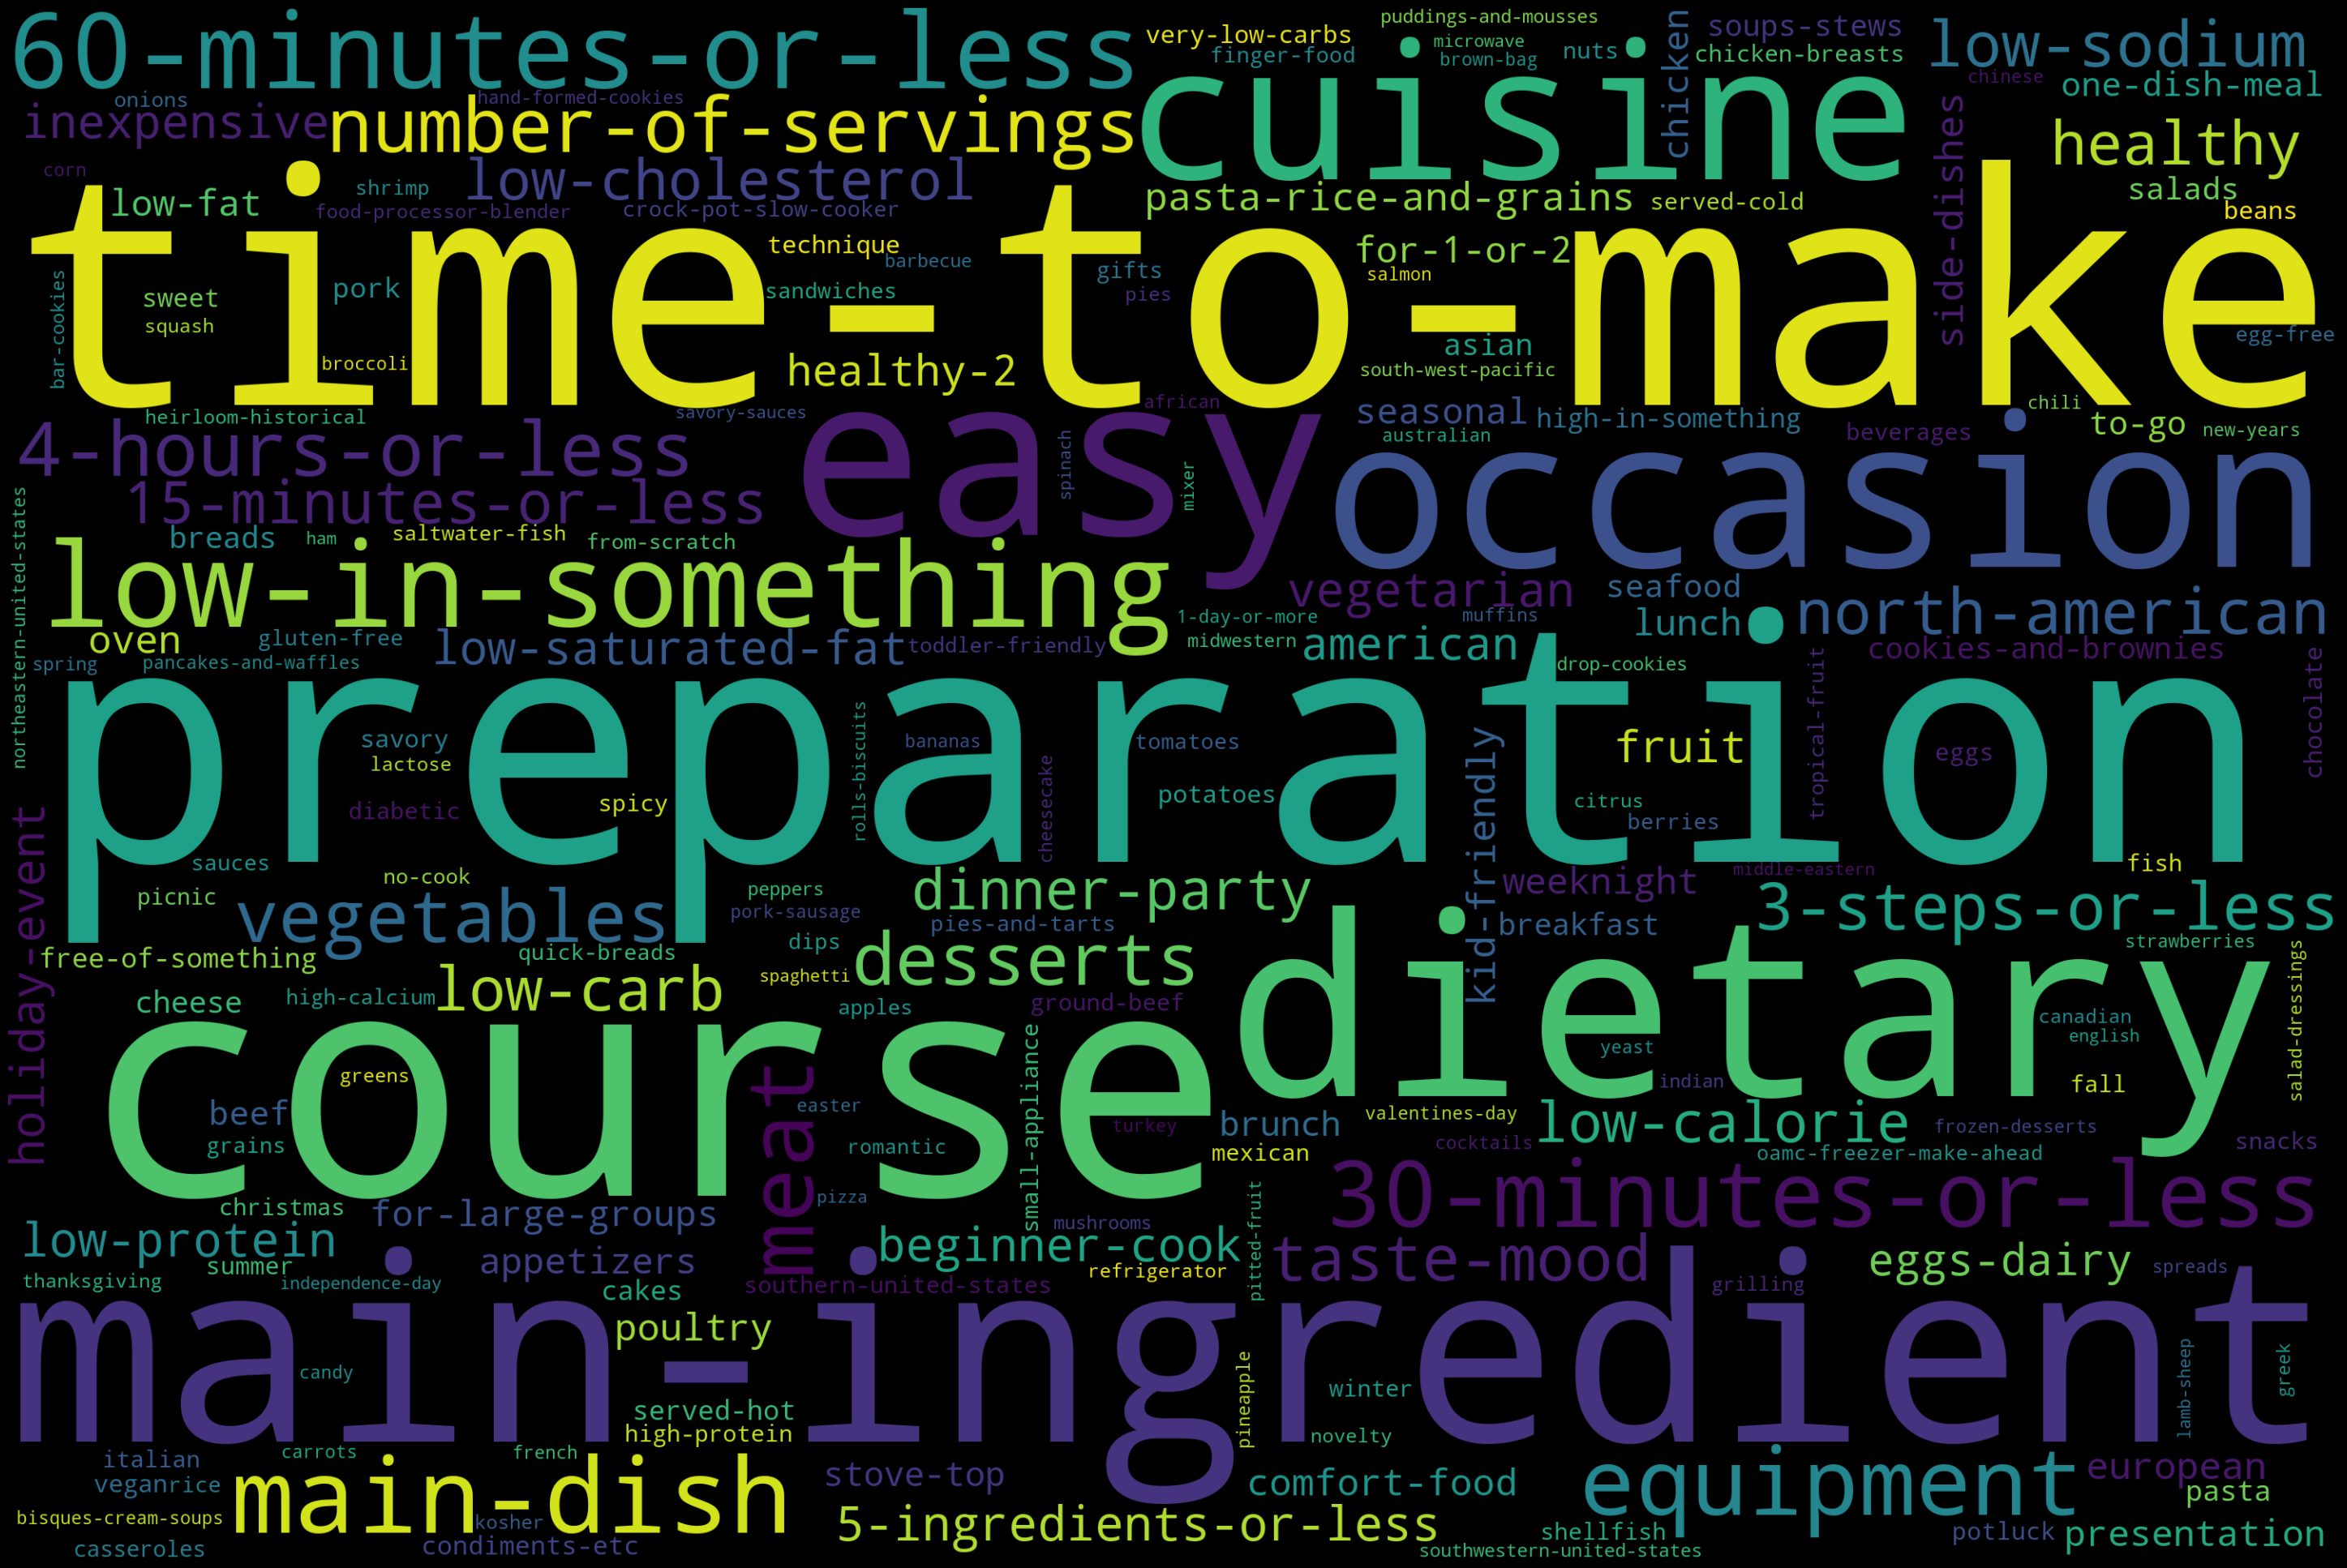

In [39]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate_from_frequencies(dict(tag_dist))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [40]:

#function for visualizing the most common tokens within a frequency distribution

def visualize_tokens(freq_dist, number, title):
    '''
    From Phase 4 Project: 
    https://github.com/CGPinDC/Tweet_NLP_Project/blob/main/Tweet_Sentiment_%20Analysis_Notebook.ipynb
    
    Inputs:
    freq_dist: pass in frequency dictionary of tokens. 
    number: number as integer of the top tokens to return
    
    title: title of graph
    '''
    

    # get tokens and frequency counts from freq_dist
    top = list(zip(*freq_dist.most_common(number)))
    tokens = top[0]
    counts = top[1]
    
    print(f'Top Tokens: {tokens[:number]}')

    # Set up plot and plot data
    fig, ax = plt.subplots(figsize = (15, 10))
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

Top Tokens: ('preparation', 'time-to-make', 'course', 'main-ingredient', 'dietary', 'easy', 'occasion', 'cuisine', 'low-in-something', '60-minutes-or-less', 'main-dish', 'equipment', '30-minutes-or-less', 'meat', 'number-of-servings', '4-hours-or-less', 'vegetables', 'desserts', '3-steps-or-less', 'taste-mood', 'north-american', 'low-sodium', 'low-carb', 'healthy', '15-minutes-or-less', 'low-cholesterol', 'low-calorie', 'dinner-party', '5-ingredients-or-less', 'low-protein', 'vegetarian', 'beginner-cook', 'holiday-event', 'low-saturated-fat', 'inexpensive', 'american', 'fruit', 'eggs-dairy', 'healthy-2', 'pasta-rice-and-grains', 'side-dishes', 'oven', 'kid-friendly', 'european', 'poultry', 'comfort-food', 'presentation', 'appetizers', 'low-fat', 'lunch')


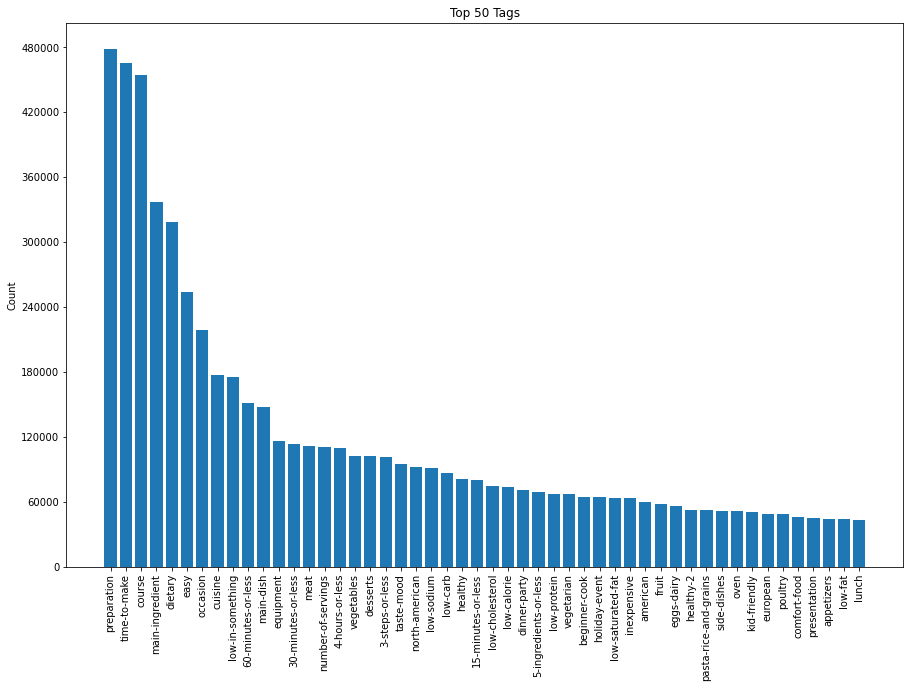

In [41]:
visualize_tokens(tag_dist, 50, "Top 50 Tags")

Since there are only 631 distinct tags I could review them one-by-one to select the ones that best fit into the "easy" category.

In [42]:
# prints each tag in an easy to read fashion
for tag in list(tag_dist):
    print(tag)

preparation
time-to-make
course
main-ingredient
dietary
easy
occasion
cuisine
low-in-something
60-minutes-or-less
main-dish
equipment
30-minutes-or-less
meat
number-of-servings
4-hours-or-less
vegetables
desserts
3-steps-or-less
taste-mood
north-american
low-sodium
low-carb
healthy
15-minutes-or-less
low-cholesterol
low-calorie
dinner-party
5-ingredients-or-less
low-protein
vegetarian
beginner-cook
holiday-event
low-saturated-fat
inexpensive
american
fruit
eggs-dairy
healthy-2
pasta-rice-and-grains
side-dishes
oven
kid-friendly
european
poultry
comfort-food
presentation
appetizers
low-fat
lunch
weeknight
for-1-or-2
chicken
seasonal
for-large-groups
stove-top
brunch
one-dish-meal
beef
to-go
seafood
salads
breakfast
breads
cookies-and-brownies
cheese
soups-stews
asian
pasta
pork
free-of-something
served-hot
cakes
high-in-something
sweet
condiments-etc
very-low-carbs
savory
technique
potatoes
vegan
chocolate
beans
summer
potluck
eggs
chicken-breasts
snacks
ground-beef
beverages
italian
ch

Recipes tagged with the following will be included in the target:

* easy     
* 30-minutes-or-less  
* 3-steps-or-less  
* 15-minutes-or-less                        
* beginner-cook                                     

The following tags were also discovered during the review.  While consisting of a small number of recipes overall since they are not for food recipes containing these tags will be removed, as we did with the napkin folding instructions. 

* bath-beauty                                            
* household-cleansers               
* homeopathy-remedies  

In [43]:
target_tags = ['easy','30-minutes-or-less', '3-steps-or-less', 
               '15-minutes-or-less', 'beginner-cook']
tags_to_remove = ['bath-beauty', 'household-cleaners', 'homeopathy-remedies']

In [44]:
# we'll remove the homeopathic and bath/beauty related recipes by indicating which
# recipes contain the undesirable tags
df['remove'] = df['tags_list'].map(lambda x: any(tag in x for tag in tags_to_remove))
df['remove'].value_counts()

False    482279
True         59
Name: remove, dtype: int64

In [45]:
df = df[df['remove'] != True]
df['remove'].value_counts()

False    482279
Name: remove, dtype: int64

### Search Term Targets

In [46]:
# begin by generating the count of unique search terms
search_term_dist = lists_to_count(df, 'search_terms_list')
type(search_term_dist)

nltk.probability.FreqDist

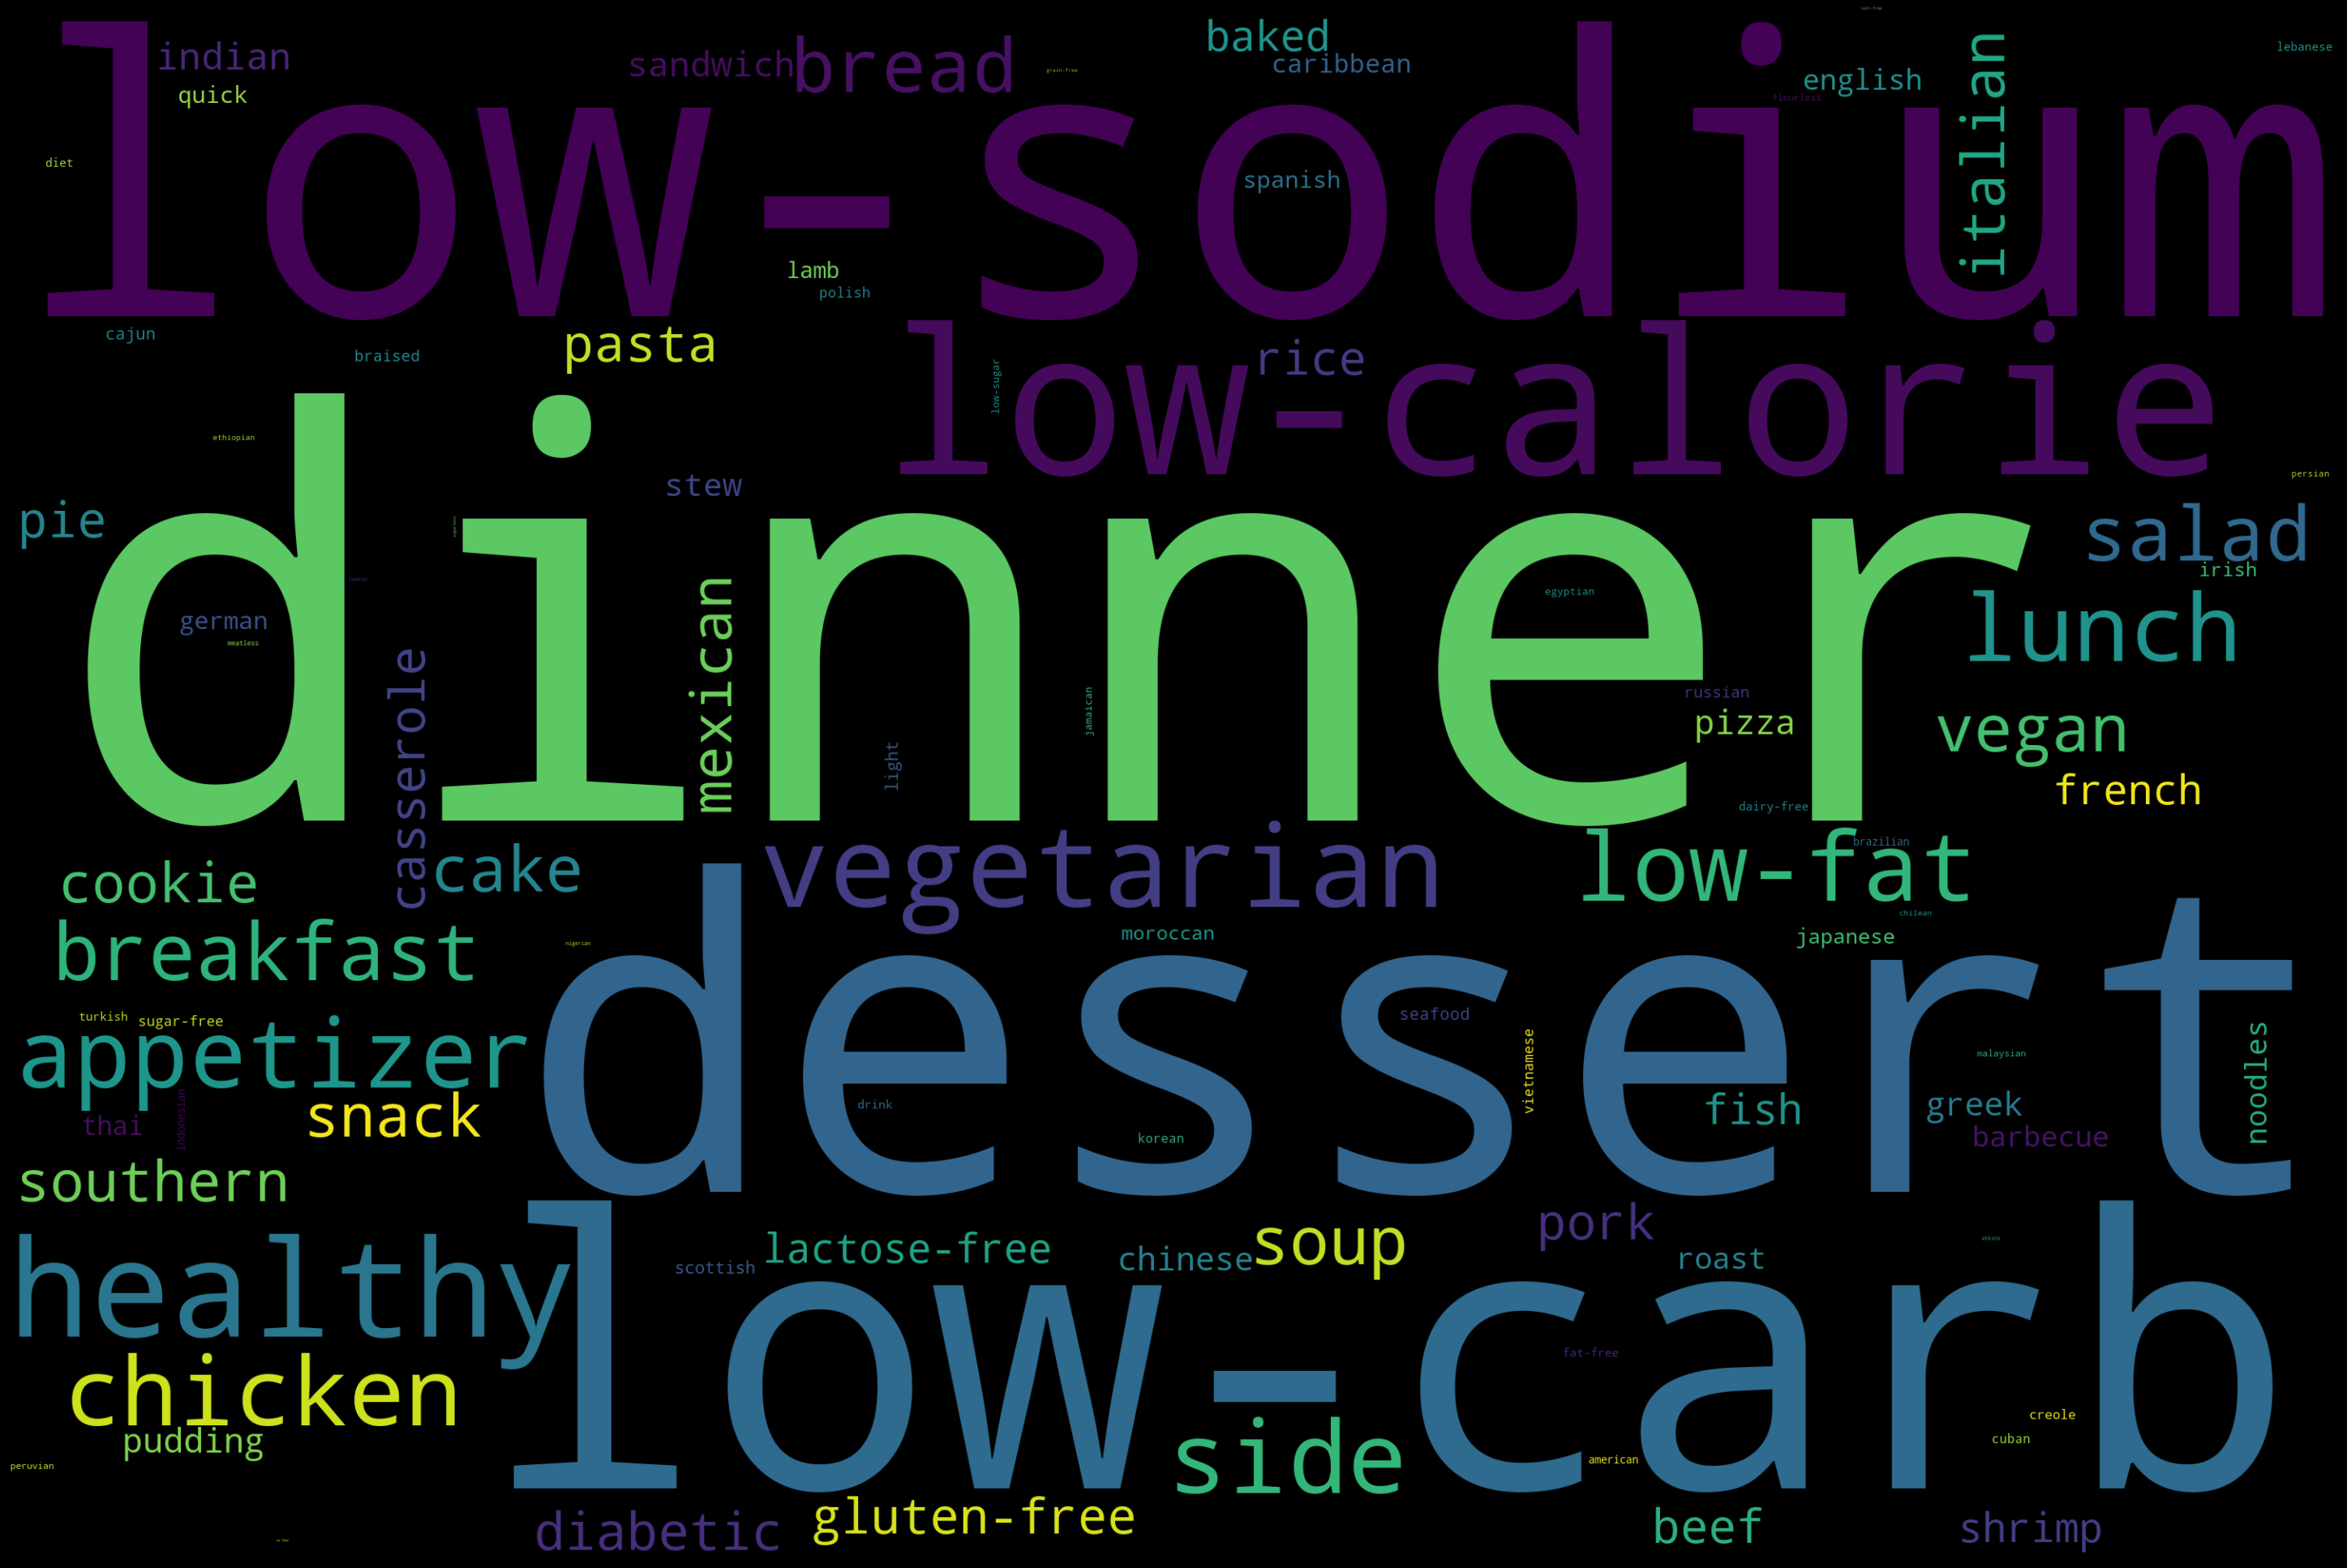

In [47]:
# Wordcloud visalization of count

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate_from_frequencies(dict(search_term_dist))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Top Tokens: ('dinner', 'dessert', 'low-sodium', 'low-carb', 'low-calorie', 'healthy', 'vegetarian', 'side', 'appetizer', 'low-fat', 'chicken', 'lunch', 'breakfast', 'salad', 'bread', 'soup', 'vegan', 'cake', 'italian', 'snack', 'mexican', 'southern', 'cookie', 'diabetic', 'pasta', 'casserole', 'pork', 'pie', 'gluten-free', 'beef', 'rice', 'baked', 'fish', 'french', 'shrimp', 'lactose-free', 'indian', 'sandwich', 'pizza', 'pudding', 'chinese', 'greek', 'stew', 'roast', 'noodles', 'english', 'barbecue', 'thai', 'caribbean', 'german')


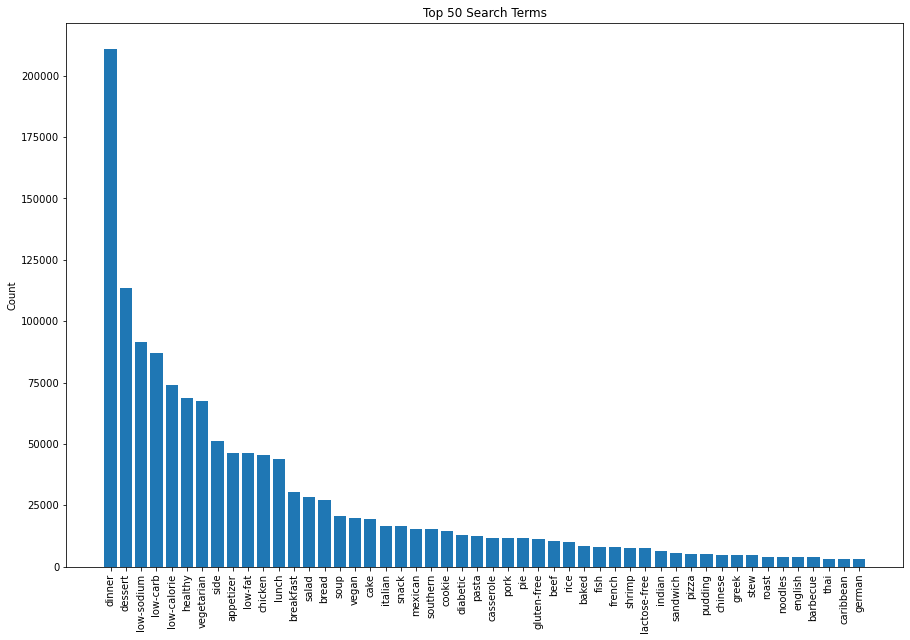

In [48]:
# show the most common search terms
visualize_tokens(search_term_dist, 50, "Top 50 Search Terms")

In [49]:
len(search_term_dist)

98

In [50]:
for term in list(search_term_dist):
    print(term)

dinner
dessert
low-sodium
low-carb
low-calorie
healthy
vegetarian
side
appetizer
low-fat
chicken
lunch
breakfast
salad
bread
soup
vegan
cake
italian
snack
mexican
southern
cookie
diabetic
pasta
casserole
pork
pie
gluten-free
beef
rice
baked
fish
french
shrimp
lactose-free
indian
sandwich
pizza
pudding
chinese
greek
stew
roast
noodles
english
barbecue
thai
caribbean
german
quick
spanish
lamb
japanese
irish
moroccan
light
scottish
cajun
seafood
russian
braised
polish
sugar-free
vietnamese
creole
korean
cuban
drink
turkish
lebanese
dairy-free
diet
fat-free
brazilian
indonesian
american
egyptian
jamaican
low-sugar
malaysian
peruvian
flourless
persian
ethiopian
chilean
meatless
atkins
nigerian
grain-free
lowfat
sugarless
salt-free
no flour
no meat
carb-free
sodium-free
flour-less


In [51]:
# generating a count of 'quick'recipes to see if that should be included in the search term target
search_term_dist['quick']

2613

Reviewing the search terms confirms that the only one that's going to be used to create this target variable is "dinner".  While there is a "quick" search term it applies to only 2,600 recipes, not a material amount. Additionally "quick" recipes are not automatically "dinner" recipes so their inclusion as a target parameter potentially adds bad data to the target set.

In [52]:
# number of recipes labeled with 'dinner' as a search term
search_term_dist['dinner']

210872

In [53]:
# creating a list with the search term target label
target_search_term = ['dinner']

### Creating Target Variable

In [54]:
# creating a column indicating if a target tag is present in the 'tags_list' column
df['target_tag'] = df['tags_list'].map(lambda x: any(tag in x for tag in target_tags))
df['target_tag'].value_counts(normalize=True)

True     0.655096
False    0.344904
Name: target_tag, dtype: float64

In [55]:
df

,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,remove,target_tag
0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...","[water, grits, salt, cheddar cheese, garlic, o...","[4 cups water, 1 cup uncooked old fas...","[I a sauce pan, bring water to a boil; slowly ...","[time-to-make, course, main-ingredient, prepar...","[low-carb, vegetarian, low-calorie, diabetic, ...",False,False
1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}","[onion, red bell pepper, garlic cloves, large ...","[1 medium onion, chopped coarse , 1 med...","[In a food processor, pulse the onion, red pep...","[60-minutes-or-less, time-to-make, course, mai...","[shrimp, dinner]",False,True
3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}","[zucchini, yellow squash, diced tomatoes, onio...","[2 zucchini, sliced , 2 small yello...",[Put all ingredients in the crock pot and cook...,"[weeknight, time-to-make, course, main-ingredi...","[italian, vegetarian, side]",False,True
4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},"[beef stew meat, flour, salt, allspice, cinnam...","[3 lbs beef stew meat, 3 tablespoons ...","[Preheat oven to 350°F., Cut beef into 1 inch ...","[time-to-make, course, main-ingredient, prepar...",[dinner],False,True
5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",{'dessert'},"[slivered almonds, cider vinegar, sugar, sugar...","[12 ounces slivered almonds, 1/4 cup ...",[Preheat oven to 375°F Place almonds in singl...,"[time-to-make, course, preparation, desserts, ...",[dessert],False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494958,276465,Blackberry Orange Scones,"The orange zest makes for a flavorful, not ove...","['unbleached flour', 'baking soda', 'butter', ...","[""2 1/2 cups unbleached flour"",""2 teaspo...",1 (83 g),8,['Sift about 2 cups of flour onto a piece of w...,"['30-minutes-or-less', 'time-to-make', 'course...","{'breakfast', 'bread'}","[unbleached flour, baking soda, butter, orange...","[2 1/2 cups unbleached flour, 2 teaspoon...",[Sift about 2 cups of flour onto a piece of wa...,"[30-minutes-or-less, time-to-make, course, pre...","[bread, breakfast]",False,True
494959,257796,Slow Cooker Garlic Chicken With Rosemary,Delicious and easy!,"['roasting chickens', 'lemons', 'rosemary spri...","[""1 (5 lb) roasting chickens, rinsed and ...",1 (340 g),6,"['Place rosemary springs, 1 lemon half, celery...","['main-ingredient', 'preparation', 'occasion',...","{'dinner', 'chicken'}","[roasting chickens, lemons, rosemary

Reviewing the above dataframe output I saw the last row contained a recipe with the '60-minutes-or-less' tag but also had one of the target tags.  Seeing how a recipe cold conceivably, if over-optimistically, be tagged with both 'easy' and '60-minutes-or-less', and because this model seeks to find recipes that are both quick and simple, going to reset the "target_tag" value to "False" if the tag list contains "60-minutes-or-less" . 

In [56]:
# small function to relabled the 'target_tag' value for recipes with '60-minutes-or-less' 
# tags
def hour_check(x):
    if '60-minutes-or-less' in x: 
        return False
    else:
        return True

In [57]:
# credit to first response on https://stackoverflow.com/questions/58562662/apply-function-on-subset-of-dataframe-rows-in-column-based-on-value-in-other-col
# for helping me figure out how to re-label the 'target_tag' column
df['target_tag'] = df.apply(lambda row:
    hour_check(row.tags_list) if row.target_tag == True else row.target_tag, axis=1)

In [58]:
df['target_tag'].value_counts(normalize=True)

True     0.515894
False    0.484106
Name: target_tag, dtype: float64

In [59]:
# identifying the recipes with the target search term
df['target_search_term'] = df['search_terms_list'].map(lambda x: any(term in x for term in target_search_term))
df['target_search_term'].value_counts(normalize=True)

False    0.562759
True     0.437241
Name: target_search_term, dtype: float64

Once the recipes were labeled with the target conditions the below code identifies recipes that meet both the search term condition and the tag condition.

In [60]:
def target_check(x):
    ''' dataframe specific function to set rows as meeting the conditions for the 
    target variable or not'''
    if (x['target_tag'] == True) and (x['target_search_term'] == True):
        return 1
    else:
        return 0

In [61]:
df['target'] = df.apply(target_check, axis=1)
df.head()

,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,remove,target_tag,target_search_term,target
0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...","[water, grits, salt, cheddar cheese, garlic, o...","[4 cups water, 1 cup uncooked old fas...","[I a sauce pan, bring water to a boil; slowly ...","[time-to-make, course, main-ingredient, prepar...","[low-carb, vegetarian, low-calorie, diabetic, ...",False,False,False,0
1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}","[onion, red bell pepper, garlic cloves, large ...","[1 medium onion, chopped coarse , 1 med...","[In a food processor, pulse the onion, red pep...","[60-minutes-or-less, time-to-make, course, mai...","[shrimp, dinner]",False,False,True,0
3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}","[zucchini, yellow squash, diced tomatoes, onio...","[2 zucchini, sliced , 2 small yello...",[Put all ingredients in the crock pot and cook...,"[weeknight, time-to-make, course, main-ingredi...","[italian, vegetarian, side]",False,True,False,0
4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},"[beef stew meat, flour, salt, allspice, cinnam...","[3 lbs beef stew meat, 3 tablespoons ...","[Preheat oven to 350°F., Cut beef into 1 inch ...","[time-to-make, course, main-ingredient, prepar...",[dinner],False,True,True,1
5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",{'dessert'},"[slivered almonds, cider vinegar, sugar, sugar...","[12 ounces slivered almonds, 1/4 cup ...",[Preheat oven to 375°F Place almonds in singl...,"[time-to-make, course, preparation, desserts, ...",[dessert],False,False,False,0


In [62]:
# checking the number of 'easy' recipes in the dataset
df['target'].value_counts(normalize=True)

0    0.796659
1    0.203341
Name: target, dtype: float64

Although the distribution of the search term target and the tag target were roughly even with both conditions applied to the recipe we now have an imbalanced dataset, which will have to be addressed prior to modeling.

The above establishes the modeless baseline for subsequent model performance - needs to correctly pick "easy" recipes at least 20% of the time to be better then guessing.

In [63]:
# final clean-up action (for now) 
df.drop(['remove'], axis=1, inplace = True)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482279 entries, 0 to 494962
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   id                        482279 non-null  int64 
 1   name                      482279 non-null  object
 2   description               482279 non-null  object
 3   ingredients               482279 non-null  object
 4   ingredients_raw_str       482279 non-null  object
 5   serving_size              482279 non-null  object
 6   servings                  482279 non-null  int64 
 7   steps                     482279 non-null  object
 8   tags                      482279 non-null  object
 9   search_terms              482279 non-null  object
 10  ingredients_list          482279 non-null  object
 11  ingredients_raw_str_list  482279 non-null  object
 12  steps_list                482279 non-null  object
 13  tags_list                 482279 non-null  object
 14  sear

## EDA

Now that the data has had it's initial cleaning (because there's always more you can do on that front) EDA could be performed to further understand the dataset's contents. To begin with we'll create some features that will be used in our first, baseline, model, which will only use length/count data in order to ensure that the target variable can't be identified by these factors alone and to provide a goal when modeling. 

In [65]:
import seaborn as sns

In [66]:
# create a number of new columns with counts of list-items and characters. 

df['num_ingredients'] = df['ingredients_list'].apply(lambda x: len(x))
df['num_steps'] = df['steps_list'].apply(lambda x: len(x))
df['num_char_description'] = df['description'].apply(lambda x: len(x))

<AxesSubplot:>

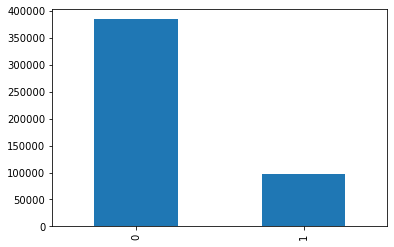

In [67]:
# visualizing our imbalanced target variables

df.target.value_counts().plot(kind ='bar')

In [68]:
# creating Series of counts to facilitate visualizations
ingredients_count = lists_to_count(df, 'ingredients_list', series = True).sort_values(ascending=False)
search_terms_count = lists_to_count(df, 'search_terms_list', series = True).sort_values(ascending=False)
tags_count = lists_to_count(df, 'tags_list', series = True).sort_values(ascending=False)

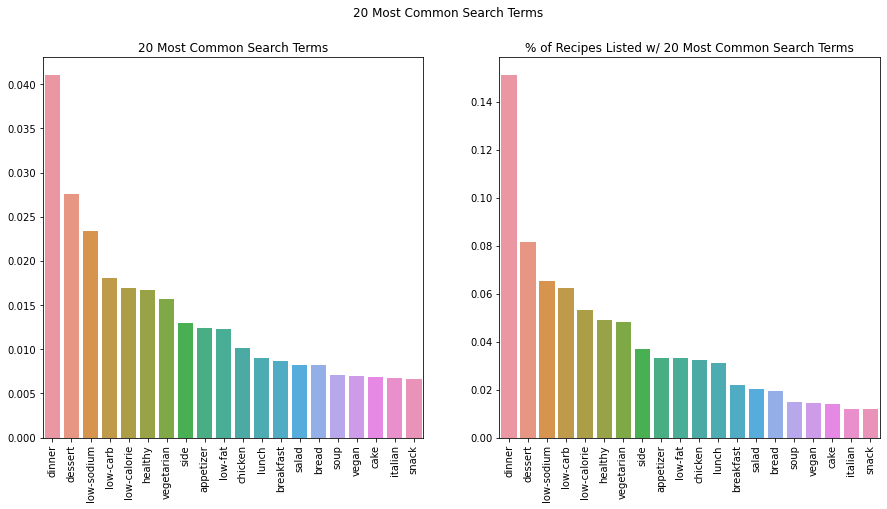

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,7))
fig.suptitle('20 Most Common Search Terms')

sns.barplot(ax = ax[0], x=search_terms_count.index[:20], y=ingredients_count.values[:20]/ingredients_count.sum())
ax[0].set_title('20 Most Common Search Terms')
ax[0].tick_params(axis = 'x', rotation = 90);

sns.barplot(ax = ax[1], x=search_terms_count.index[:20], y=search_terms_count.values[:20]/search_terms_count.sum())
ax[1].set_title('% of Recipes Listed w/ 20 Most Common Search Terms')
ax[1].tick_params(axis = 'x', rotation = 90);

Text(0.5, 1.0, '20 Most Common Tags')

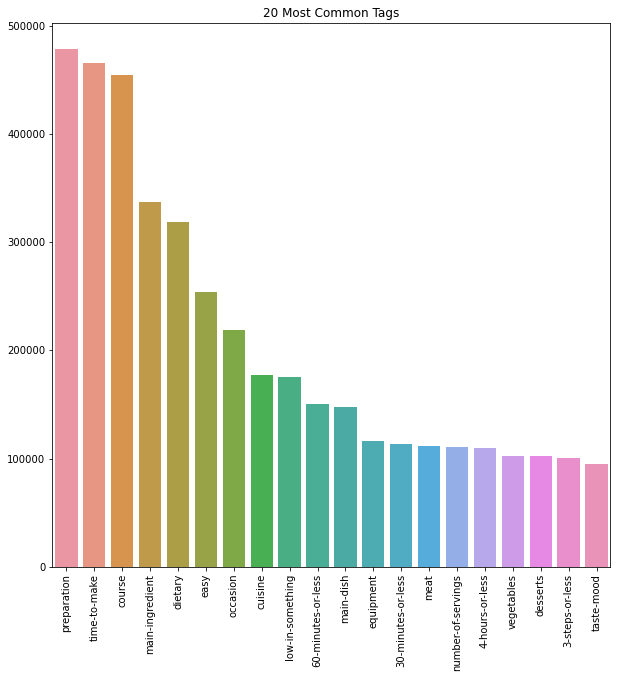

In [70]:
fig, ax = plt.subplots(figsize=(10,10))

# plotting the 20 most frequently used ingredients 
all_plot = sns.barplot(x=tags_count.index[:20], y=tags_count.values[:20], ax=ax)
plt.xticks(rotation=90);
plt.title('20 Most Common Tags')

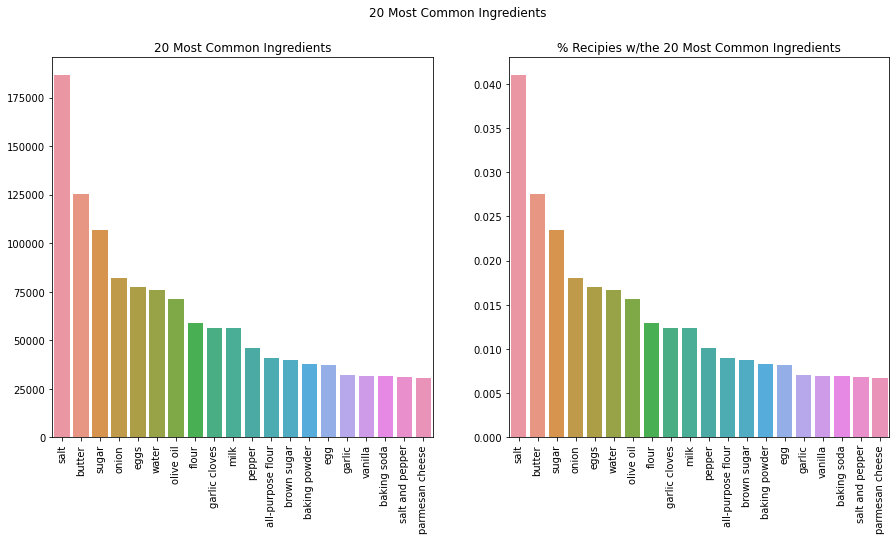

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,7))
fig.suptitle('20 Most Common Ingredients')

# plotting the 20 most frequently used ingredients 
sns.barplot(ax = ax[0],x=ingredients_count.index[:20], y=ingredients_count.values[:20])
ax[0].set_title('20 Most Common Ingredients')
ax[0].tick_params(axis = 'x', rotation = 90);


sns.barplot(ax=ax[1], x=ingredients_count.index[:20], y=ingredients_count.values[:20]/ingredients_count.sum())
ax[1].set_title('% Recipies w/the 20 Most Common Ingredients')
ax[1].tick_params(axis = 'x', rotation = 90);


The most common ingredients are, as to be expected, cooking essentials: salt, butter, sugar, etc... Decided to investigate this further as model performance might improve by adding to add very common ingredients to our stopwords list prior to vectorization if they are common in both target and non-target recipes.  The other options for handling this overlap, and others I may have missed, is via the document frequency parameters in the vectorizer. 

In [72]:
# creating ingredient counts for target and non-target recipes
easy_ingredient_count = lists_to_count(df[df['target'] == 1], 'ingredients_list', series = True).sort_values(ascending=False)
not_easy_ingredient_count = lists_to_count(df[df['target'] == 0], 'ingredients_list', series = True).sort_values(ascending=False)


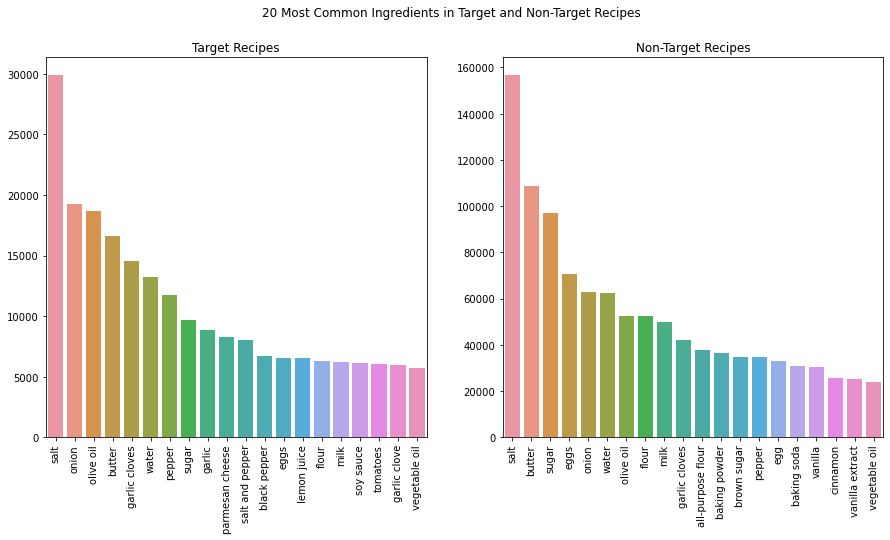

In [73]:
# plotting the 20 most frequently used ingredients in each type of recipe 

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,7))
fig.suptitle('20 Most Common Ingredients in Target and Non-Target Recipes')

sns.barplot(ax=ax[0], x=easy_ingredient_count.index[:20], y=easy_ingredient_count.values[:20])
ax[0].set_title('Target Recipes')
ax[0].tick_params(axis = 'x', rotation = 90);


sns.barplot(ax=ax[1], x=not_easy_ingredient_count.index[:20], y=not_easy_ingredient_count.values[:20])
ax[1].set_title('Non-Target Recipes')
ax[1].tick_params(axis = 'x', rotation = 90);

Comparing the two graphs the Non-Target recipes have more baking related ingredients, such as flour, brown sugar, and baking powder, then the Target recipes do.  This makes sense given that in general baking takes more time then cooking and because the Non-Target column contains recipes with 'dessert' as a search term, which is the second most common search term after 'dinner'.

### Exploring the 'steps' and 'description' Columns

The 'steps' and 'description' column text will be the core of the information used in the modeling process and so requires a better understanding of their raw data as well as what emerges after the initial pre-processing steps are taken (converting to lowercase, removing punctuation, etc.). 

In [74]:
import re


In [75]:
def basic_cleaning(df, column):
    ''' Takes in a dataframe and the name of the column to be cleaned.  The contents of the column 
    which need to be strings, are converted to lowercase, have their punctuation and numbers removed,
    and are finally stripped of whitespaces
    
    Input:
    df - dataframe with column to be cleaned
    column - column containing strings
    
    Returns: 
    Dataframe with new, cleaned, column added'''
    new_col = 'cleaned_' +column
    # convert to lowercase
    df[new_col] = df[column].apply(lambda x: x.lower())
    
    # remove punctuation and non-characters
    df[new_col] = df[new_col].apply(lambda x: re.sub(r'[^\w\s]','',x))
    df[new_col] = df[new_col].apply(lambda x: re.sub('[0-9\n]',' ',x))

    #strip whitespace
    df[new_col] = df[new_col].apply(lambda x: re.sub('[ ]{2,}',' ',x))
    
    return df

In [76]:
# cleaning steps column 
df = basic_cleaning(df, 'steps')

In [77]:
# review a cleaned step to confirm it appears as expected
step = df['cleaned_steps'][0]
step

'i a sauce pan bring water to a boil slowly add grits and salt stirring constantly reduce heatsimmer uncovered for minutes or untill thickened stirrin occasionally add cheese and garlic stir until cheese is melted spray inch baking dish with nonstick cooking spray cover and refrigerate for to hours or until frim before starting the grill coat the grill rack with nonstick cooking spray cut the grits into inch squares brush both sides with olive oil grill covered over medium heat for to minutes on each side or until lightly browned'

One interesting thing to note in the above 'steps' example is that because the recipes are user submitted they may contain spelling errors - in the above case you can see the first word is missing an 'n' -  as they aren't required to meet any proofreading standards. The Spark NLP library contains a spell checker that's used after tokenization and which I may use to resolve this issue. 

In [78]:
# tokenizing steps
df['step_tokens'] = df['cleaned_steps'].apply(lambda x: x.split())
df.head()

,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,target_tag,target_search_term,target,num_ingredients,num_steps,num_char_description,cleaned_steps,step_tokens
0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...","[water, grits, salt, cheddar cheese, garlic, o...","[4 cups water, 1 cup uncooked old fas...","[I a sauce pan, bring water to a boil; slowly ...","[time-to-make, course, main-ingredient, prepar...","[low-carb, vegetarian, low-calorie, diabetic, ...",False,False,0,6,4,301,i a sauce pan bring water to a boil slowly add...,"[i, a, sauce, pan, bring, water, to, a, boil, ..."
1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}","[onion, red bell pepper, garlic cloves, large ...","[1 medium onion, chopped coarse , 1 med...","[In a food processor, pulse the onion, red pep...","[60-minutes-or-less, time-to-make, course, mai...","[shrimp, dinner]",False,True,0,13,10,138,in a food processor pulse the onion red pepper...,"[in, a, food, processor, pulse, the, onion, re..."
3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}","[zucchini, yellow squash, diced tomatoes, onio...","[2 zucchini, sliced , 2 small yello...",[Put all ingredients in the crock pot and cook...,"[weeknight, time-to-make, course, main-ingredi...","[italian, vegetarian, side]",True,False,0,9,1,57,put all ingredients in the crock pot and cook ...,"[put, all, ingredients, in, the, crock, pot, a..."
4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},"[beef stew meat, flour, salt, allspice, cinnam...","[3 lbs beef stew meat, 3 tablespoons ...","[Preheat oven to 350°F., Cut beef into 1 inch ...","[time-to-make, course, main-ingredient, prepar...",[dinner],True,True,1,14,6,392,preheat oven to f cut beef into inch cubes com...,"[preheat, oven, to, f, cut, beef, into, inch, ..."
5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",{'dessert'},"[slivered almonds, cider vinegar, sugar, sugar...","[12 ounces slivered almonds, 1/4 cup ...",[Preheat oven to 375°F Place almonds in singl...,"[time-to-make, course, preparation, desserts, ...",[dessert],False,False,0,8,4,164,preheat oven to f place almonds in single laye...,"[preheat, oven, to, f, place, almonds, in, sin..."


In [79]:
# geting word counts
token_count = lists_to_count(df, 'step_tokens', series = True).sort_values(ascending=False)

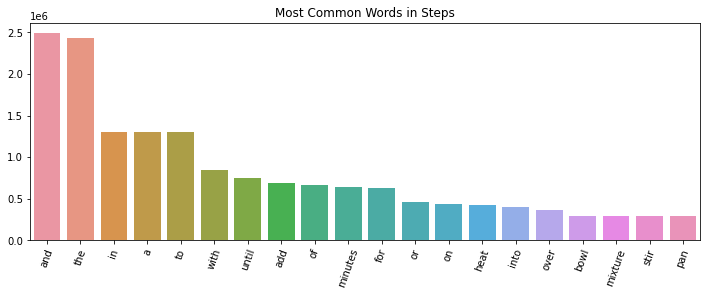

In [80]:
#visualization of the most common words in 'steps'

fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(ax=ax, x=token_count.index[:20], y=token_count.values[:20])
ax.set_title('Most Common Words in Steps')
ax.set_xticklabels(token_count.index[:20])
ax.tick_params(axis='x', labelrotation=70);

The most common words in 'steps' at this point are, unsurprisingly, stopwords. In order to get a better picture of the data these will be removed and the top 20 words will be replotted. 

In [81]:
from nltk.corpus import stopwords

In [82]:
# creating a list of the nltk's English-language stopwords
stop_words = stopwords.words('english')
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [83]:
# a small function to quickly remove stopwords from the 'step_tokens' column 
def remove_stop_words(count, stop_words):
    for x in count.index:
        if x in stop_words:
            count = count.drop(x)
    
    return count

In [84]:
token_count = remove_stop_words(token_count, stop_words)


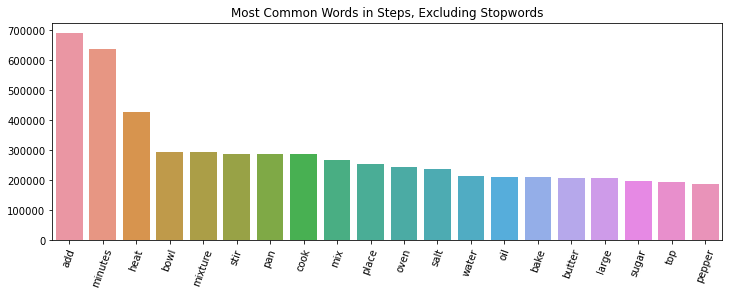

In [85]:
# re-plotting the most common words in steps

fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(ax=ax, x=token_count.index[:20], y=token_count.values[:20])
ax.set_title('Most Common Words in Steps, Excluding Stopwords')
ax.set_xticklabels(token_count.index[:20])
ax.tick_params(axis='x', labelrotation=70);

Having reviewed the common contents of 'steps' the process is repeated for the 'description' column 

In [86]:
# cleaning and tokenizing 'description'
df = basic_cleaning(df, 'description')
df['description_tokens'] = df['cleaned_description'].apply(lambda x: x.split())
df.head()

,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,target_tag,target_search_term,target,num_ingredients,num_steps,num_char_description,cleaned_steps,step_tokens,cleaned_description,description_tokens
0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...","[water, grits, salt, cheddar cheese, garlic, o...","[4 cups water, 1 cup uncooked old fas...","[I a sauce pan, bring water to a boil; slowly ...","[time-to-make, course, main-ingredient, prepar...","[low-carb, vegetarian, low-calorie, diabetic, ...",False,False,0,6,4,301,i a sauce pan bring water to a boil slowly add...,"[i, a, sauce, pan, bring, water, to, a, boil, ...",we love grits this is another good way to serv...,"[we, love, grits, this, is, another, good, way..."
1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}","[onion, red bell pepper, garlic cloves, large ...","[1 medium onion, chopped coarse , 1 med...","[In a food processor, pulse the onion, red pep...","[60-minutes-or-less, time-to-make, course, mai...","[shrimp, dinner]",False,True,0,13,10,138,in a food processor pulse the onion red pepper...,"[in, a, food, processor, pulse, the, onion, re...",simple easy and very tasty for when you are in...,"[simple, easy, and, very, tasty, for, when, yo..."
3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}","[zucchini, yellow squash, diced tomatoes, onio...","[2 zucchini, sliced , 2 small yello...",[Put all ingredients in the crock pot and cook...,"[weeknight, time-to-make, course, main-ingredi...","[italian, vegetarian, side]",True,False,0,9,1,57,put all ingredients in the crock pot and cook ...,"[put, all, ingredients, in, the, crock, pot, a...",this is a good recipe for weight watchers it i...,"[this, is, a, good, recipe, for, weight, watch..."
4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},"[beef stew meat, flour, salt, allspice, cinnam...","[3 lbs beef stew meat, 3 tablespoons ...","[Preheat oven to 350°F., Cut beef into 1 inch ...","[time-to-make, course, main-ingredient, prepar...",[dinner],True,True,1,14,6,392,preheat oven to f cut beef into inch cubes com...,"[preheat, oven, to, f, cut, beef, into, inch, ...",this is a fabulous stew that came from one of ...,"[this, is, a, fabulous, stew, that, came, from..."
5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",{'dessert'},"[slivered almonds, cider vinegar, sugar, sugar...","[12 ounces slivered almonds, 1/4 cup ...",[Preheat oven to 375°F Place almonds in singl...,"[time-to-make, course, preparation, desserts, ...",[dessert],False,Fals

In [87]:
# getting word count
description_count = lists_to_count(df, 'description_tokens', series = True).sort_values(ascending=False)

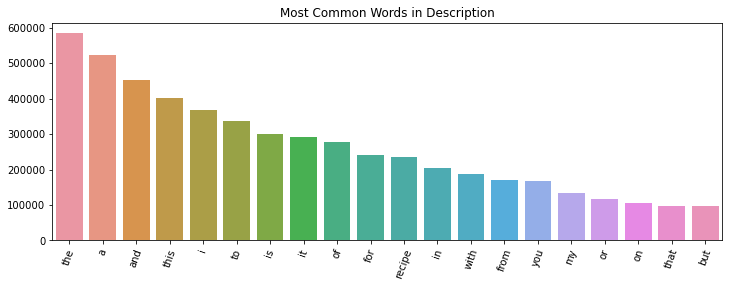

In [88]:
#visualization of the most common words in 'description'

fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(ax=ax, x=description_count.index[:20], y=description_count.values[:20])
ax.set_title('Most Common Words in Description')
ax.set_xticklabels(description_count.index[:20])
ax.tick_params(axis='x', labelrotation=70);

Unsurprisingly the initial visualization is predominantly stopwords. 

In [89]:
# remove stopwords from 'description_count'
description_count = remove_stop_words(description_count, stop_words)


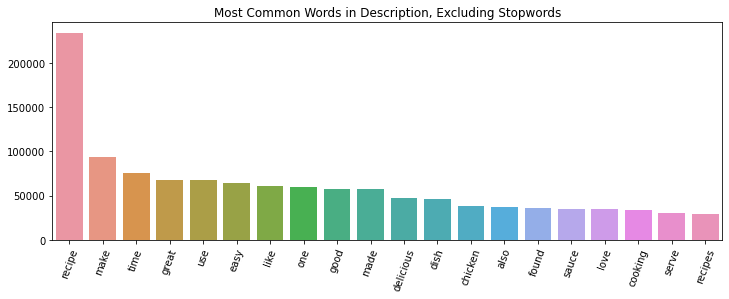

In [90]:
# plotting most common words again
fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(ax=ax, x=description_count.index[:20], y=description_count.values[:20])
ax.set_title('Most Common Words in Description, Excluding Stopwords')
ax.set_xticklabels(description_count.index[:20])
ax.tick_params(axis='x', labelrotation=70);

Once stopwords were removed from both 'steps' and 'description' there were no words remaining that seemed to need to be added to the stopwords list. 

## Baseline Model

This model uses the length data generated earlier to ensure that NLP is an appropriate approach for predicting the difficulty level of a recipe. To begin with we'll create a dataframe that only uses the 'num' columns in the current dataframe.

In [91]:


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from imblearn.under_sampling import RandomUnderSampler


In [92]:
# Creating a numbers only db

X_numbers_df = df[['num_ingredients','num_steps', 'num_char_description']]
y_numbers_df = df['target']
X_numbers_df.head()

,num_ingredients,num_steps,num_char_description
0,6,4,301
1,13,10,138
3,9,1,57
4,14,6,392
5,8,4,164


In [93]:
y_numbers_df.value_counts()

0    384212
1     98067
Name: target, dtype: int64

The first action that needs to be taken with the 'numbers-only' data is to address the fact that it is unbalanced.  Traditionally the two primary means of handling this are:

- creating more examples of the minority class using SMOTE or something like it
- removing examples from the majority class so that it has the same number of records as the minority class

Because the imbalance in this dataset is great enough that using SMOTE would result in there being three times as much synthetic target data as there is real data, and because the dataset is large enough to remove examples that do not match the target and still have almost 200,000 records remaining, undersampling will be used to balance the dataset using Imbalanced Learn's RandomUnderSampler, which under-samples the majority class by randomly picking samples, in this case without replacement. 

In [94]:
# please note that this step can be taken prior to the train/test split as no data is 
# transformed, only removed. 
rus = RandomUnderSampler(random_state=50)
X_res, y_res = rus.fit_resample(X_numbers_df, y_numbers_df)
y_res.value_counts()

1    98067
0    98067
Name: target, dtype: int64

The balanced dataset can now be spit into train and test sets.  Because this is only a baseline model a valedation set is not being created. 

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = .3)

In [96]:
# checking the balance on the train set
y_train.value_counts()

0    68662
1    68631
Name: target, dtype: int64

In [97]:
# checking the balance on the test set
y_test.value_counts()

1    29436
0    29405
Name: target, dtype: int64

In [98]:
# creating the StandardScaler object to run the data through so that undue weight isn't given 
# to columns with higher numbers. 

scalar = StandardScaler()
X_train_numbers_scaled = scalar.fit_transform(X_train, y_train)
X_train_numbers_scaled


array([[ 0.18583746, -0.34517058,  1.50261092],
       [-0.82592749, -0.34517058, -0.46279829],
       [-1.07886873, -0.34517058, -1.08597682],
       ...,
       [ 0.69171994,  0.65388085, -0.13922482],
       [-0.06710378, -0.34517058,  0.40006429],
       [-0.06710378, -0.59493344,  0.63974834]])

In [99]:
# transforming the testing data
X_test_numbers_scaled = scalar.transform(X_test)
X_test_numbers_scaled

array([[-0.06710378,  0.15435513, -0.22910634],
       [-0.57298625,  0.15435513, -0.31299576],
       [-0.82592749, -0.8446963 , -0.24708264],
       ...,
       [ 1.19760241,  0.9036437 ,  0.74161406],
       [-0.06710378,  0.40411799, -0.17517743],
       [ 0.69171994,  0.9036437 , -0.72645074]])

The custom evaluate function to judge the performance of this, and other, models. 

In [104]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, cv=5):
    '''
Function takes in estimator, training data, test data, 
and the cross validation splitting strategy, and returns the accuracy, precision, recall, f1 and the ROC-AUC
scores for the model as well as a confusion matrix visualization.  From Phase 3 Project: 
https://github.com/Nindorph/TanzanianWaterWells/blob/main/Modeling_Final.ipynb and Lindsey Berlin’s evaluate function
found at: 
https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb
------------------------------------------------------------------------------------------
Inputs: 
-Estimator - Estimator object  
-X_tr – X_train dataframe
-X_te – X_test dataframe
-Y_tr – y_train dataframe
-Y_te – y_test dataframe
-Cv – If cross_val  set to true this determines the cross-validation splitting strategy.  
        Takes in all value options for sklearn.model_selection_cross_val_score “cv” parameter:
        - None, to use the default 5-fold cross validation,
        - int, to specify the number of folds in a (Stratified)KFold,
        - CV splitter,
        - An iterable yielding (train, test) splits as arrays of indices


Returns – nothing is returned '''

    #Cross-Validate
    output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                            scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])
    #Printing out the mean of all of our evaluating metrics across the cross validation. 
    #Accuracy, precisionc recall, f1, and roc auc
    print('Results of Cross-Validation:\n')
    print(f'Average accuracy: {output["test_accuracy"].mean()}\
    +/- {output["test_accuracy"].std()}')
    print(f'Average precision: {output["test_precision"].mean()}\
    +/- {output["test_precision"].std()}')
    print(f'**Average recall: {output["test_recall"].mean()}\
    +/- {output["test_recall"].std()}')
    print(f'Average f1 score: {output["test_f1"].mean()}\
    +/- {output["test_f1"].std()}')
    print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
    +/- {output["test_roc_auc"].std()}\n')
    print('+'*20)


    #Fitting the estimator to our X and y train data
    estimator.fit(X_tr, y_tr)
    #getting predictions for X train
    tr_preds = estimator.predict(X_tr)
    #getting predictions for X test
    te_preds = estimator.predict(X_te)

    #Creating a confusion matrix from our data with custom labels
    print('\nResults of Train-Test Split Validation:')
    plot_confusion_matrix(estimator, X_te, y_te, cmap='mako')
    plt.show()

    #Printing our final evaluating metrics across X train
    #Evaluating using accuracy, precision, recall, f1, roc auc
    print("\nTraining Scores:")
    print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train precision: {precision_score(y_tr, tr_preds)}")
    print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
    print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
    print("<>"*10)
    #Printing our final evaluating metrics across X test
    #Evaluating using accuracy, precision, recall, f1, roc auc
    print("\nTesting Scores:")
    print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test precision: {precision_score(y_te, te_preds)}")
    print(f"**Test recall: {recall_score(y_te, te_preds)}")
    print(f"Test f1 score: {f1_score(y_te, te_preds)}")
    print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")


A LogisticRegression model for our baseline as I've had good results with those in past NLP projects and anticipate it performing well with the text data. It's not just me though, in their book [*Speech and Language Processing*](https://web.stanford.edu/~jurafsky/slp3/5.pdf) authors Daniel Jurafsky & James H. Martin state "In natural language processing, logistic regression is the baseline supervised machine learning algorithm for classification."

In [105]:
# create very basic model
logreg = LogisticRegression()

Results of Cross-Validation:

Average accuracy: 0.5594021290168791    +/- 0.0017118473886772434
Average precision: 0.5510412535020139    +/- 0.0012889545300151376
**Average recall: 0.6401918147405983    +/- 0.005313114039236846
Average f1 score: 0.5922730788330833    +/- 0.0027910273312865843
Average roc_auc: 0.5762760445571813    +/- 0.002353386861703015

++++++++++++++++++++

Results of Train-Test Split Validation:


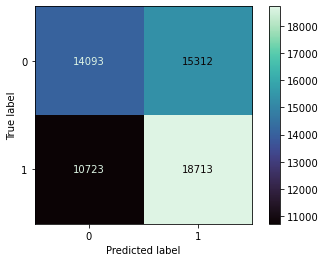


Training Scores:
Train accuracy: 0.559576963137232
Train precision: 0.5511939400020066
**Train recall: 0.6403811688595533
Train f1 score: 0.5924498035277386
Train roc_auc: 0.5595952041612148

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.5575364116857293
Test precision: 0.5499779573842762
**Test recall: 0.635718168229379
Test f1 score: 0.589748034225745
Test roc_auc: 0.5574952004214401


In [106]:
# evaluate performance of count-related recipe data
evaluate(logreg, X_train_numbers_scaled, X_test_numbers_scaled, 
         y_train, y_test)

The numbers-only model has an accuracy score of 56%, which with the balanced dataset means that this model only works slightly better then guessing. 

## Preprocessing

Now that the baseline has been established for a model using recipe text it's time to move onwards towards the real modeling. Before this can be done the dataframe needs to be vectorized - I'll be using both CountVectorizer and TfidfVectorizer, run through a series of simple models, because I want to see if one of the two has a better performance. 

In [107]:
# review what columns we need to vectorize
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482279 entries, 0 to 494962
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   id                        482279 non-null  int64 
 1   name                      482279 non-null  object
 2   description               482279 non-null  object
 3   ingredients               482279 non-null  object
 4   ingredients_raw_str       482279 non-null  object
 5   serving_size              482279 non-null  object
 6   servings                  482279 non-null  int64 
 7   steps                     482279 non-null  object
 8   tags                      482279 non-null  object
 9   search_terms              482279 non-null  object
 10  ingredients_list          482279 non-null  object
 11  ingredients_raw_str_list  482279 non-null  object
 12  steps_list                482279 non-null  object
 13  tags_list                 482279 non-null  object
 14  sear

In [108]:
# creating a dataframe with the text that will be used in the model as well as the target
df_strings = df[['ingredients','description','steps','target']]
df_strings.head()

,ingredients,description,steps,target
0,"['water', 'grits', 'salt', 'cheddar cheese', '...","We love grits, this is another good way to ser...","['I a sauce pan, bring water to a boil; slowly...",0
1,"['onion', 'red bell pepper', 'garlic cloves', ...","Simple, easy and very tasty for when you are i...","['In a food processor, pulse the onion, red pe...",0
3,"['zucchini', 'yellow squash', 'diced tomatoes'...",This is a good recipe for weight watchers. It ...,['Put all ingredients in the crock pot and coo...,0
4,"['beef stew meat', 'flour', 'salt', 'allspice'...",This is a fabulous stew that came from one of ...,"['Preheat oven to 350°F.', ""Cut beef into 1 in...",1
5,"['slivered almonds', 'cider vinegar', 'sugar',...",This is one of our standard holiday gift recip...,['Preheat oven to 375°F Place almonds in sing...,0


In [109]:
# use the basic_cleaning function on each non-list column of the dataframe 
df_strings = basic_cleaning(df_strings, 'description')
df_strings = basic_cleaning(df_strings, 'steps')
df_strings = basic_cleaning(df_strings, 'ingredients')

<ipython-input-75-b60c57689ccb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[column].apply(lambda x: x.lower())
<ipython-input-75-b60c57689ccb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[new_col].apply(lambda x: re.sub(r'[^\w\s]','',x))
<ipython-input-75-b60c57689ccb>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [110]:
# confirming the cleaning process worked as expected
df_strings.head()

,ingredients,description,steps,target,cleaned_description,cleaned_steps,cleaned_ingredients
0,"['water', 'grits', 'salt', 'cheddar cheese', '...","We love grits, this is another good way to ser...","['I a sauce pan, bring water to a boil; slowly...",0,we love grits this is another good way to serv...,i a sauce pan bring water to a boil slowly add...,water grits salt cheddar cheese garlic olive oil
1,"['onion', 'red bell pepper', 'garlic cloves', ...","Simple, easy and very tasty for when you are i...","['In a food processor, pulse the onion, red pe...",0,simple easy and very tasty for when you are in...,in a food processor pulse the onion red pepper...,onion red bell pepper garlic cloves large shri...
3,"['zucchini', 'yellow squash', 'diced tomatoes'...",This is a good recipe for weight watchers. It ...,['Put all ingredients in the crock pot and coo...,0,this is a good recipe for weight watchers it i...,put all ingredients in the crock pot and cook ...,zucchini yellow squash diced tomatoes onion ga...
4,"['beef stew meat', 'flour', 'salt', 'allspice'...",This is a fabulous stew that came from one of ...,"['Preheat oven to 350°F.', ""Cut beef into 1 in...",1,this is a fabulous stew that came from one of ...,preheat oven to f cut beef into inch cubes com...,beef stew meat flour salt allspice cinnamon bl...
5,"['slivered almonds', 'cider vinegar', 'sugar',...",This is one of our standard holiday gift recip...,['Preheat oven to 375°F Place almonds in sing...,0,this is one of our standard holiday gift recip...,preheat oven to f place almonds in single laye...,slivered almonds cider vinegar sugar sugar sal...


In [111]:
# dropping unnecessary columns
df_strings.drop(columns = ['ingredients','description','steps'], inplace=True)
df_strings

C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,target,cleaned_description,cleaned_steps,cleaned_ingredients
0,0,we love grits this is another good way to serv...,i a sauce pan bring water to a boil slowly add...,water grits salt cheddar cheese garlic olive oil
1,0,simple easy and very tasty for when you are in...,in a food processor pulse the onion red pepper...,onion red bell pepper garlic cloves large shri...
3,0,this is a good recipe for weight watchers it i...,put all ingredients in the crock pot and cook ...,zucchini yellow squash diced tomatoes onion ga...
4,1,this is a fabulous stew that came from one of ...,preheat oven to f cut beef into inch cubes com...,beef stew meat flour salt allspice cinnamon bl...
5,0,this is one of our standard holiday gift recip...,preheat oven to f place almonds in single laye...,slivered almonds cider vinegar sugar sugar sal...
...,...,...,...,...
494958,0,the orange zest makes for a flavorful not over...,sift about cups of flour onto a piece of waxed...,unbleached flour baking soda butter orange zes...
494959,1,delicious and easy,place rosemary springs lemon half celery onion...,roasting chickens lemons rosemary sprigs papri...
494960,0,this is a recipe from the frugal gourmet cooki...,in a large pan heat oil and brown roast on bot...,boneless beef chuck roast olive oil tawny port...
494961,1,cabbage and sausage in tomato sauce,saute bacon in large pan until browned leave i...,cabbage condensed tomato soup kielbasa onions ...


In [112]:
# splitting the data to X and y 
y = df_strings['target']
X = df_strings.drop('target', axis=1)

In [113]:
# undersampling the data in the same manner used with the baseline model
rus = RandomUnderSampler(random_state=50)
X_res, y_res = rus.fit_resample(X, y)
y_res.value_counts()

1    98067
0    98067
Name: target, dtype: int64

In [114]:
# splitting the data, including creating a holdout set
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = .3, 
                                                    random_state=50)
X_test, X_holdout, y_test, y_holdout = train_test_split(X_test, y_test, test_size = .3,
                                                        random_state=50)

In [115]:
print(f'Train {y_train.value_counts()}')
print(f'Test  {y_test.value_counts()}')
print(f'Holdout {y_holdout.value_counts()}')

Train 0    68716
1    68577
Name: target, dtype: int64
Test  1    20714
0    20474
Name: target, dtype: int64
Holdout 0    8877
1    8776
Name: target, dtype: int64


To prepare the data for vectorization the columns containing text will have to be combined into a single string that will be used in the model to meet the input requirements for the vectorizers.

In [116]:
# creating a new column compatible with vectorizer inputs 
X_train['combined'] = X_train['cleaned_description'].str.cat(X_train[['cleaned_steps',
                                                                      'cleaned_ingredients']],sep=" ")

X_train.head()

<ipython-input-116-9835fa94be06>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['combined'] = X_train['cleaned_description'].str.cat(X_train[['cleaned_steps',


,cleaned_description,cleaned_steps,cleaned_ingredients,combined
47827,i tried some recipes for making sweet sour sau...,add the oil sugar and vinegar to a small sauce...,sugar vinegar ketchup water pineapple juice co...,i tried some recipes for making sweet sour sau...
129467,this is the soup that moroccans traditionally ...,place the lamb turmeric black pepper cinnamon ...,lamb ground turmeric ground black pepper groun...,this is the soup that moroccans traditionally ...
184947,i really loved my friends lemon chicken pasta ...,cook chicken your favorite way i usually salt ...,chicken pasta avocados olive oil green onion f...,i really loved my friends lemon chicken pasta ...
98991,a nice change to the tradtional gratin \r \r w...,preheat the oven to cfan cgas put the cream ga...,double cream garlic cloves fresh thyme leave p...,a nice change to the tradtional gratin \r \r w...
159123,this has amazed our guests for years but is so...,in a large nonreactive pot with lid melt butte...,unsalted butter garlic cloves fresh ground bla...,this has amazed our guests for years but is so...


In [117]:
# repeating this with the test data
X_test['combined'] = X_test['cleaned_description'].str.cat(X_test[['cleaned_steps',
                                                                'cleaned_ingredients']],sep=" ")
X_test.head()

,cleaned_description,cleaned_steps,cleaned_ingredients,combined
97436,my favorite dinner party soup cooking the drie...,cover mushrooms with cold water and soak overn...,dried wild mushrooms beef stock butter onion c...,my favorite dinner party soup cooking the drie...
147954,this is from the wsu extension office i havent...,saute in pan on medium heat in oil zucchini mu...,zucchini sliced mushrooms onions flour tortill...,this is from the wsu extension office i havent...
10086,recipe by tyler florencethis is soooo good the...,first thing to do is to steam the artichokes i...,fresh parsley water garlic cloves bay leaves d...,recipe by tyler florencethis is soooo good the...
178888,im very picky about my chili as i get terrible...,note for a soupier chili use a oz bottle of v ...,v vegetable juice chili seasoning mix chili st...,im very picky about my chili as i get terrible...
136500,this is a very quick recipe so easy my husband...,thaw frozen tilapia soak in milk for hour disc...,tilapia fillet lowfat milk panko breadcrumbs m...,this is a very quick recipe so easy my husband...


In [118]:
print(f'Train {y_train.value_counts()}')
print(f'Test  {y_test.value_counts()}')
print(f'Holdout {y_holdout.value_counts()}')

Train 0    68716
1    68577
Name: target, dtype: int64
Test  1    20714
0    20474
Name: target, dtype: int64
Holdout 0    8877
1    8776
Name: target, dtype: int64


## Modeling  

To begin the modeling process basic, nlp appropriate,  models are created and run with both types of vectorized datasets.  This will identify which models deserve more attention and fine tuning.

In [120]:
from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


### CountVectorizer

In [121]:
# having the CountVectorizer remove stop words
countvect = CountVectorizer(stop_words=stop_words, ngram_range=(1,1))

In [122]:
X_train_CV = countvect.fit_transform(X_train.combined)
X_test_CV = countvect.transform(X_test.combined)

In [123]:
classifiers = {
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "MultinomialNB": MultinomialNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=3), #to keep the initial modeling quick
    "RandomForestClassifier": RandomForestClassifier(max_depth=3),
    "LogisticRegression": LogisticRegression(penalty = 'elasticnet',l1_ratio =.5, solver='saga'),
    "AdaBoostClassifier": AdaBoostClassifier(),
}

BernoulliNB
Results of Cross-Validation:

Average accuracy: 0.6679437230396654        +/- 0.002355052279753311
Average precision: 0.6288082257136919        +/- 0.0020276220377248248
**Average recall: 0.8182334449353144        +/- 0.002507729848902346
Average f1 score: 0.7111205451612952        +/- 0.0019129888678486272
Average roc_auc: 0.7372718944460759        +/- 0.002784791836307464

++++++++++++++++++++

Results of Train-Test Split Validation:


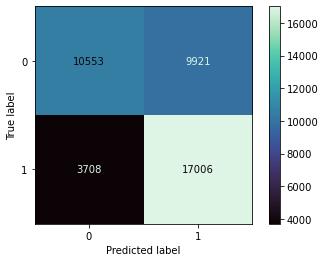


Training Scores:
Train accuracy: 0.6890300306643456
Train precision: 0.6456277358299481
**Train recall: 0.8366507721247649
Train f1 score: 0.7288305683290568
Train roc_auc: 0.6891793356519977

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6691026512576479
Test precision: 0.6315594013443755
**Test recall: 0.8209906343535773
Test f1 score: 0.7139228815516047
Test roc_auc: 0.6682124217972829
ComplementNB
Results of Cross-Validation:

Average accuracy: 0.6707115333681354        +/- 0.0029129439936998233
Average precision: 0.6324789939954696        +/- 0.002630152109688461
**Average recall: 0.8134505701673669        +/- 0.002158602833565433
Average f1 score: 0.7116373254647977        +/- 0.002197934438393689
Average roc_auc: 0.7262719748920242        +/- 0.0031016082520470938

++++++++++++++++++++

Results of Train-Test Split Validation:


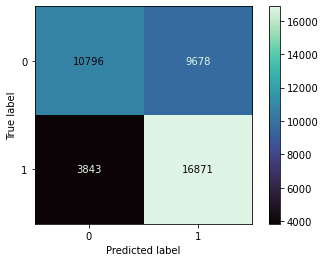


Training Scores:
Train accuracy: 0.6866118447408098
Train precision: 0.6452801437392679
**Train recall: 0.8274494363999592
Train f1 score: 0.7250980742936733
Train roc_auc: 0.6867542891878136

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6717247742060795
Test precision: 0.635466495913217
**Test recall: 0.8144733030800425
Test f1 score: 0.713919979688128
Test roc_auc: 0.670888111928807
MultinomialNB
Results of Cross-Validation:

Average accuracy: 0.6706678318495076        +/- 0.002958196156416409
Average precision: 0.6324599938550718        +/- 0.0026618226264351437
**Average recall: 0.8133339117031323        +/- 0.0021728521007704483
Average f1 score: 0.7115807129568601        +/- 0.0022387734212169336
Average roc_auc: 0.726271771725853        +/- 0.0031020696605689423

++++++++++++++++++++

Results of Train-Test Split Validation:


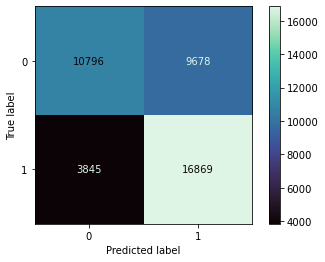


Training Scores:
Train accuracy: 0.6866118447408098
Train precision: 0.6452900569764929
**Train recall: 0.8274056899543579
Train f1 score: 0.725087535461446
Train roc_auc: 0.6867542449422526

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6716762163737011
Test precision: 0.6354390326590575
**Test recall: 0.8143767500241382
Test f1 score: 0.7138655551088635
Test roc_auc: 0.6708398354008549
DecisionTreeClassifier
Results of Cross-Validation:

Average accuracy: 0.6302506252702182        +/- 0.0022799506841740536
Average precision: 0.5937228203195488        +/- 0.001953660168237351
**Average recall: 0.8227976672134598        +/- 0.002589747690459817
Average f1 score: 0.6897339868719056        +/- 0.0015606707081552013
Average roc_auc: 0.6633773484533071        +/- 0.00293947412646339

++++++++++++++++++++

Results of Train-Test Split Validation:


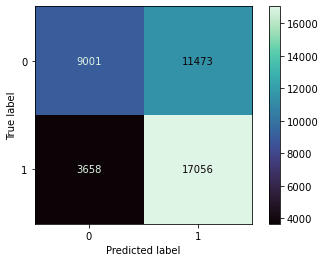


Training Scores:
Train accuracy: 0.6302287807827056
Train precision: 0.5935241976138464
**Train recall: 0.8240809600886595
Train f1 score: 0.6900539095077324
Train roc_auc: 0.6304248446755656

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6326357191414975
Test precision: 0.5978478039889236
**Test recall: 0.8234044607511828
Test f1 score: 0.6927279004122414
Test roc_auc: 0.6315176059739112
RandomForestClassifier
Results of Cross-Validation:

Average accuracy: 0.6552336845919686        +/- 0.004243029092889223
Average precision: 0.618659804839427        +/- 0.004344891354898234
**Average recall: 0.8078075351165623        +/- 0.01070761748648875
Average f1 score: 0.7006428754182938        +/- 0.0039656137311953705
Average roc_auc: 0.7157695130564956        +/- 0.004305378109224001

++++++++++++++++++++

Results of Train-Test Split Validation:


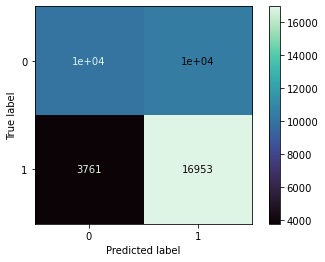


Training Scores:
Train accuracy: 0.6584093872229465
Train precision: 0.6193554070273187
**Train recall: 0.8202166907272117
Train f1 score: 0.7057731156756214
Train roc_auc: 0.6585730406310836

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6557978051859765
Test precision: 0.6194234352734846
**Test recall: 0.8184319783721155
Test f1 score: 0.7051556683235238
Test roc_auc: 0.6548445913155878
LogisticRegression


C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear

Results of Cross-Validation:

Average accuracy: 0.7047919473296484        +/- 0.002985944526235162
Average precision: 0.6937834325764138        +/- 0.0038622508896213165
**Average recall: 0.7321842996627488        +/- 0.002389190477041988
Average f1 score: 0.7124592333492616        +/- 0.0023000278531779043
Average roc_auc: 0.7734116543390103        +/- 0.002221917266614091

++++++++++++++++++++


C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



Results of Train-Test Split Validation:


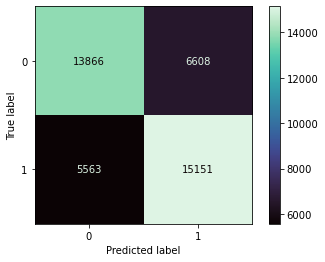


Training Scores:
Train accuracy: 0.7360171312448559
Train precision: 0.7227289008899788
**Train recall: 0.7649795120813101
Train f1 score: 0.7432542521765618
Train roc_auc: 0.7360464240655693

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7045013110614742
Test precision: 0.6963095730502321
**Test recall: 0.7314376750024139
Test f1 score: 0.7134414804699456
Test roc_auc: 0.7043434345511239
AdaBoostClassifier
Results of Cross-Validation:

Average accuracy: 0.6770264861023729        +/- 0.0016943112551757664
Average precision: 0.661160057975897        +/- 0.0022787948166429362
**Average recall: 0.724951552492322        +/- 0.0034026466143041315
Average f1 score: 0.6915796698058235        +/- 0.0015065836250136842
Average roc_auc: 0.7461105398796818        +/- 0.0016015419234329733

++++++++++++++++++++

Results of Train-Test Split Validation:


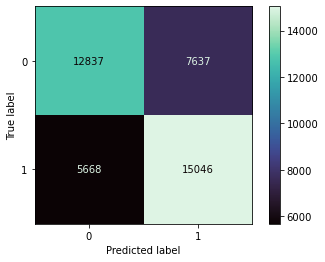


Training Scores:
Train accuracy: 0.6773542715214905
Train precision: 0.6611233509409922
**Train recall: 0.7263805649124342
Train f1 score: 0.6922173662305539
Train roc_auc: 0.6774038571695299

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6769690201029426
Test precision: 0.6633161398404092
**Test recall: 0.7263686395674424
Test f1 score: 0.69341198700371
Test roc_auc: 0.6766794843827248


In [124]:
for name, sklearn_classifier in classifiers.items():
    classifier = sklearn_classifier
    print(name)
    evaluate(classifier, X_train_CV, X_test_CV, y_train, y_test)

### TfidfVectorizer

In [125]:
tfidf = TfidfVectorizer(stop_words = stop_words)
X_train_tfidf = tfidf.fit_transform(X_train.combined)
X_test_tfidf = tfidf.transform(X_test.combined)

In [129]:
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

In [126]:
# removing KNeighborsClassifier from the list of options as it takes too long to run
# with mediocre results when used with the CountVectorizer

classifiers = {
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "MultinomialNB": MultinomialNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=3), #to keep the initial modeling quick
    "RandomForestClassifier": RandomForestClassifier(max_depth=3),
    "LogisticRegression": LogisticRegression(penalty = 'elasticnet',l1_ratio =.5, solver='saga'),
    "AdaBoostClassifier": AdaBoostClassifier(),
}

BernoulliNB
Results of Cross-Validation:

Average accuracy: 0.6679437230396654        +/- 0.002355052279753311
Average precision: 0.6288082257136919        +/- 0.0020276220377248248
**Average recall: 0.8182334449353144        +/- 0.002507729848902346
Average f1 score: 0.7111205451612952        +/- 0.0019129888678486272
Average roc_auc: 0.7372718944460759        +/- 0.002784791836307464

++++++++++++++++++++

Results of Train-Test Split Validation:


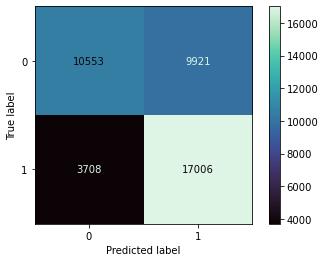


Training Scores:
Train accuracy: 0.6890300306643456
Train precision: 0.6456277358299481
**Train recall: 0.8366507721247649
Train f1 score: 0.7288305683290568
Train roc_auc: 0.6891793356519977

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6691026512576479
Test precision: 0.6315594013443755
**Test recall: 0.8209906343535773
Test f1 score: 0.7139228815516047
Test roc_auc: 0.6682124217972829
ComplementNB
Results of Cross-Validation:

Average accuracy: 0.6767569923431171        +/- 0.002685799123032517
Average precision: 0.6413717247113541        +/- 0.0026018594467296205
**Average recall: 0.8004578828241925        +/- 0.0018746067605576115
Average f1 score: 0.7121355622030373        +/- 0.001978348558231771
Average roc_auc: 0.749902220537832        +/- 0.003027434533991026

++++++++++++++++++++

Results of Train-Test Split Validation:


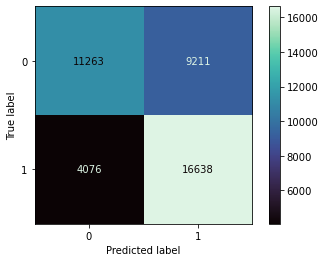


Training Scores:
Train accuracy: 0.6971367804622232
Train precision: 0.658093230264699
**Train recall: 0.8193417618151858
Train f1 score: 0.7299180940132634
Train roc_auc: 0.6972603797142756

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6774060405943478
Test precision: 0.6436612634918178
**Test recall: 0.803224872067201
Test f1 score: 0.7146446749565105
Test roc_auc: 0.6766686048330534
MultinomialNB
Results of Cross-Validation:

Average accuracy: 0.6767569931389056        +/- 0.0026251702785135564
Average precision: 0.6414577304862454        +/- 0.0025648688226974745
**Average recall: 0.8000787507892781        +/- 0.0018291914138574743
Average f1 score: 0.7120383996765376        +/- 0.0019157732080198335
Average roc_auc: 0.749902220537832        +/- 0.003027434533991026

++++++++++++++++++++

Results of Train-Test Split Validation:


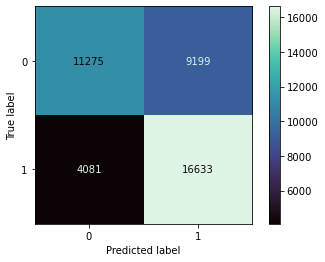


Training Scores:
Train accuracy: 0.697238752157794
Train precision: 0.6582716107256703
**Train recall: 0.8190647009930443
Train f1 score: 0.729917806439037
Train roc_auc: 0.6973619680528409

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6775759930076721
Test precision: 0.6438912976153608
**Test recall: 0.8029834894274404
Test f1 score: 0.7146908434666781
Test roc_auc: 0.6768409681190147
DecisionTreeClassifier
Results of Cross-Validation:

Average accuracy: 0.6305128365040875        +/- 0.0020716757364631884
Average precision: 0.5942676548309842        +/- 0.0018375529576019885
**Average recall: 0.8204499451239758        +/- 0.003048503280868797
Average f1 score: 0.6892732858430838        +/- 0.0014567472373081848
Average roc_auc: 0.663055875539024        +/- 0.0024670581470042884

++++++++++++++++++++

Results of Train-Test Split Validation:


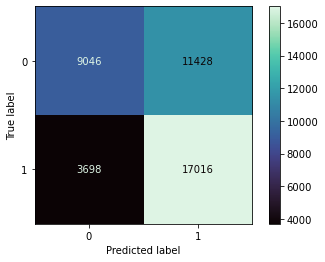


Training Scores:
Train accuracy: 0.6307167881829372
Train precision: 0.5942074809498213
**Train recall: 0.822126952185135
Train f1 score: 0.6898285798186691
Train roc_auc: 0.6309103821988601

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6327571137224435
Test precision: 0.5982280973140205
**Test recall: 0.8214733996330984
Test f1 score: 0.6922983034297571
Test roc_auc: 0.6316510301867748
RandomForestClassifier
Results of Cross-Validation:

Average accuracy: 0.6553720212733034        +/- 0.006234625201656038
Average precision: 0.6233273717282259        +/- 0.005050379524424526
**Average recall: 0.7835860756195121        +/- 0.00969601189805187
Average f1 score: 0.6943075387192814        +/- 0.0059674958186840665
Average roc_auc: 0.7161064596256986        +/- 0.004941657596469747

++++++++++++++++++++

Results of Train-Test Split Validation:


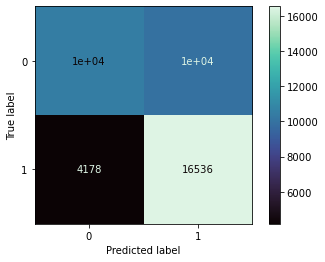


Training Scores:
Train accuracy: 0.6574406561150241
Train precision: 0.6224399336258041
**Train recall: 0.798605946600172
Train f1 score: 0.6996033545601451
Train roc_auc: 0.6575834319996611

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6556278527726522
Test precision: 0.6230125838294025
**Test recall: 0.7983006662160858
Test f1 score: 0.6998476383951244
Test roc_auc: 0.6547916342704927
LogisticRegression
Results of Cross-Validation:

Average accuracy: 0.7102109937320492        +/- 0.0013818965212887846
Average precision: 0.699253318003423        +/- 0.0016925889402733649
**Average recall: 0.7366901576238443        +/- 0.0026499199864471216
Average f1 score: 0.7174799331804131        +/- 0.0014341735471591994
Average roc_auc: 0.7845830512199936        +/- 0.0016728732962070642

++++++++++++++++++++

Results of Train-Test Split Validation:


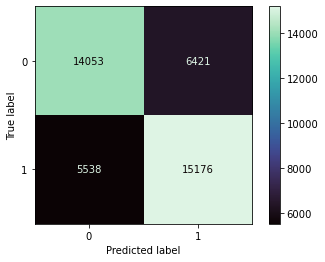


Training Scores:
Train accuracy: 0.7319382634220244
Train precision: 0.719864928450829
**Train recall: 0.7585050381323184
Train f1 score: 0.738680015621117
Train roc_auc: 0.7319651333044735

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7096484412935806
Test precision: 0.7026901884520999
**Test recall: 0.7326445882012166
Test f1 score: 0.7173548249864102
Test roc_auc: 0.7095136587582229
AdaBoostClassifier
Results of Cross-Validation:

Average accuracy: 0.678410389011874        +/- 0.0019428737357940935
Average precision: 0.6644931152129286        +/- 0.002818424532377354
**Average recall: 0.7194833158918691        +/- 0.006592810246041841
Average f1 score: 0.6908708797403835        +/- 0.002527923487022844
Average roc_auc: 0.7486999508644392        +/- 0.0020978925804910654

++++++++++++++++++++

Results of Train-Test Split Validation:


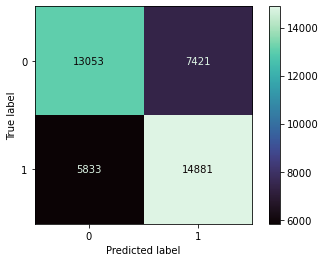


Training Scores:
Train accuracy: 0.6810689547172835
Train precision: 0.6672558967992659
**Train recall: 0.7210726628461438
Train f1 score: 0.6931212110593266
Train roc_auc: 0.6811094148388702

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.6782072448285908
Test precision: 0.667249574029235
**Test recall: 0.7184030124553442
Test f1 score: 0.691882090384973
Test roc_auc: 0.6779716537318238


In [127]:
for name, sklearn_classifier in classifiers.items():
    classifier = sklearn_classifier
    print(name)
    evaluate(classifier, X_train_tfidf, X_test_tfidf, y_train, y_test)

An interesting result of running the basic models with both CountVectorized and TdifdVectorized data is seeing how both types produce near identical results with this data set, meaning that we could proceed with using either on the "scores" front.  That being said the data transformed with TdifdVectorizer did not trigger a convergence warning while being run through the LogisticRegression model, our best performing one, so we will proceed with using that dataset as the default. A possible next step would be to use both vectorizers on the dataset to see if that improves performance.

## Delete This

adaboost  
Average accuracy: 0.678410389011874        +/- 0.0019428737357940935  
Average precision: 0.6644931152129286        +/- 0.002818424532377354  
Average recall: 0.7194833158918691        +/- 0.006592810246041841  
Average f1 score: 0.6908708797403835        +/- 0.002527923487022844  
Average roc_auc: 0.7486999508644392     

LogisticRegression  
Results of Cross-Validation:

Average accuracy: 0.7102109937320492        +/- 0.0013818965212887846  
Average precision: 0.699253318003423        +/- 0.0016925889402733649  
Average recall: 0.7366901576238443        +/- 0.0026499199864471216  
Average f1 score: 0.7174799331804131        +/- 0.0014341735471591994  
Average roc_auc: 0.7845830512199936        +/- 0.0016728732962070642  
  
DecisionTreeClassifier  
Results of Cross-Validation:  

Average accuracy: 0.6305128365040875        +/- 0.0020716757364631884  
Average precision: 0.5942676548309842        +/- 0.0018375529576019885  
Average recall: 0.8204499451239758        +/- 0.003048503280868797  
Average f1 score: 0.6892732858430838        +/- 0.0014567472373081848  
Average roc_auc: 0.663055875539024        +/- 0.0024670581470042884  

MultinomialNB  
Results of Cross-Validation:  

Average accuracy: 0.6767569931389056        +/- 0.0026251702785135564  
Average precision: 0.6414577304862454        +/- 0.0025648688226974745  
Average recall: 0.8000787507892781        +/- 0.0018291914138574743  
Average f1 score: 0.7120383996765376        +/- 0.0019157732080198335  
Average roc_auc: 0.749902220537832        +/- 0.003027434533991026  

ComplementNB  
Results of Cross-Validation:  

Average accuracy: 0.6767569923431171        +/- 0.002685799123032517  
Average precision: 0.6413717247113541        +/- 0.0026018594467296205  
Average recall: 0.8004578828241925        +/- 0.0018746067605576115  
Average f1 score: 0.7121355622030373        +/- 0.001978348558231771  
Average roc_auc: 0.749902220537832        +/- 0.003027434533991026    

BernoulliNB  
Results of Cross-Validation:  

Average accuracy: 0.6679437230396654        +/- 0.002355052279753311  
Average precision: 0.6288082257136919        +/- 0.0020276220377248248  
**Average recall: 0.8182334449353144        +/- 0.002507729848902346  
Average f1 score: 0.7111205451612952        +/- 0.0019129888678486272  
Average roc_auc: 0.7372718944460759        +/- 0.002784791836307464  



The evaluation results for each model show Logistic Regression, MultinomialNB, and ComplementNB having the best performance with the current dataset.  Interestingly the Naieve Bayes' models had near identical outputs and so moving forward we'll only work with ComplementNB as that's best suited for inbalanced datasets, which is not an issue.  Per the documentation MultinomialNB nominally requires integer feature counts even though it will word with the TdifdVectorizer's fractional outputs. Despite this we'll continue to use the Tdifd dataset as MultinomialNB performed slightly better using it. 

Although it didn't fare particularly well when compared with the other models the DecisionTree will also undergo some hyperparameter tuning as the initial model was in part designed to be processed quickly so simply increasing the max_depth outputs may provide better results.

## Hyperparameter Tuning

In [131]:
from sklearn.pipeline import Pipeline

### MultinomialNB  

The MultinomialNB model takes in only 3 parameters: alpha, fit_prior, and class_prior, making it an excellent starting point for hyperparameter tuning. 

In [132]:
#creating a pipeline including the TfidfVectorizer as well as the model

mnb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [142]:
mnb_params = {
    'tfidf__max_df': [.5, .95, 1],
    'tfidf__min_df': [.05, .1, 1],
    'mnb__fit_prior': [True, False]
}



In [143]:
mnb_clf = GridSearchCV(mnb_pipe, mnb_params)
mnb_clf.fit(X_train.combined, y_train)

mnb_results = pd.DataFrame(mnb_clf.cv_results_)
mnb_results

C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__fit_prior,param_tfidf__max_df,param_tfidf__min_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.965661,0.065794,2.501618,0.025552,True,0.5,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.650097,0.652282,0.657380,0.650266,0.652779,0.652561,0.002634,8
1,9.916038,0.061899,2.446347,0.011761,True,0.5,0.1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.643286,0.646127,0.646600,0.642691,0.644111,0.644563,0.001545,12
2,10.203095,0.052868,2.619587,0.023444,True,0.5,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.673586,0.676645,0.681052,0.674339,0.676998,0.676524,0.002613,3
3,9.906418,0.055593,2.448342,0.023860,True,0.95,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.650861,0.652937,0.658291,0.651395,0.653544,0.653405,0.002631,6
4,9.906428,0.036256,2.419746,0.013514,True,0.95,0.1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.644743,0.646600,0.648858,0.644147,0.646624,0.646195,0.001658,10
5,10.256241,0.070232,2.560577,0.033690,True,0.95,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.673586,0.677009,0.681707,0.674922,0.677143,0.676874,0.002759,2
6,9.647015,0.059509,0.000000,0.000000,True,1,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 1, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
7,9.674976,0.048318,0.000000,0.000000,True,1,0.1,"{'mnb__fit_prior': True, 'tfidf__max_df': 1, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
8,9.818348,0.084822,2.431551,0.016398,True,1,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 1, '...",0.500892,0.504352,0.501876,0.502768,0.502914,0.502560,0.001151,14
9,9.850005,0.017454,2.483353,0.010597,False,0.5,0.05,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.5...",0.650424,0.652318,0.657708,0.650266,0.652706,0.652684,0.002695,7


In [146]:
mnb_results.sort_values(['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__fit_prior,param_tfidf__max_df,param_tfidf__min_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,10.253904,0.031836,2.565783,0.022885,False,0.95,1,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.9...",0.673550,0.677046,0.681707,0.674849,0.677289,0.676888,0.002783,1
5,10.256241,0.070232,2.560577,0.033690,True,0.95,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.673586,0.677009,0.681707,0.674922,0.677143,0.676874,0.002759,2
2,10.203095,0.052868,2.619587,0.023444,True,0.5,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.673586,0.676645,0.681052,0.674339,0.676998,0.676524,0.002613,3
11,10.183689,0.022359,2.619974,0.023976,False,0.5,1,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.5...",0.673440,0.676463,0.681161,0.674266,0.676888,0.676444,0.002691,4
12,9.875622,0.029626,2.445957,0.028096,False,0.95,0.05,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.9...",0.650898,0.653228,0.658181,0.651249,0.653507,0.653413,0.002600,5
3,9.906418,0.055593,2.448342,0.023860,True,0.95,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.650861,0.652937,0.658291,0.651395,0.653544,0.653405,0.002631,6
9,9.850005,0.017454,2.483353,0.010597,False,0.5,0.05,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.5...",0.650424,0.652318,0.657708,0.650266,0.652706,0.652684,0.002695,7
0,9.965661,0.065794,2.501618,0.025552,True,0.5,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.650097,0.652282,0.657380,0.650266,0.652779,0.652561,0.002634,8
13,9.851966,0.052688,2.398511,0.009189,False,0.95,0.1,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.9...",0.644561,0.646928,0.648858,0.644111,0.646842,0.646260,0.001734,9
4,9.906428,0.036256,2.419746,0.013514,True,0.95,0.1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.644743,0.646600,0.648858,0.644147,0.646624,0.646195,0.001658,10


Looking at the top performing model the common hyperparameter was a max_df of .95 in the vectorization stage - this is a parameter that causes any word appearing more then a certain amount or percentage of times in the dataset to be dropped. This parameter was paired with a min_df, the smallest number or percentage of times a word can appear before being dropped, in the best performing values but since this is the default value of the hyperparameter it can be excluded from future GridSearches.

In [148]:
mnb_params2 = {
    'tfidf__max_df': [.9, .95, .98],
    'mnb__alpha' : [.5,1,1.5]
}

In [149]:
mnb_clf2 = GridSearchCV(mnb_pipe, mnb_params)
mnb_clf2.fit(X_train.combined, y_train)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__fit_prior,param_tfidf__max_df,param_tfidf__min_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,10.253904,0.031836,2.565783,0.022885,False,0.95,1,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.9...",0.673550,0.677046,0.681707,0.674849,0.677289,0.676888,0.002783,1
5,10.256241,0.070232,2.560577,0.033690,True,0.95,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.673586,0.677009,0.681707,0.674922,0.677143,0.676874,0.002759,2
2,10.203095,0.052868,2.619587,0.023444,True,0.5,1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.673586,0.676645,0.681052,0.674339,0.676998,0.676524,0.002613,3
11,10.183689,0.022359,2.619974,0.023976,False,0.5,1,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.5...",0.673440,0.676463,0.681161,0.674266,0.676888,0.676444,0.002691,4
12,9.875622,0.029626,2.445957,0.028096,False,0.95,0.05,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.9...",0.650898,0.653228,0.658181,0.651249,0.653507,0.653413,0.002600,5
3,9.906418,0.055593,2.448342,0.023860,True,0.95,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.650861,0.652937,0.658291,0.651395,0.653544,0.653405,0.002631,6
9,9.850005,0.017454,2.483353,0.010597,False,0.5,0.05,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.5...",0.650424,0.652318,0.657708,0.650266,0.652706,0.652684,0.002695,7
0,9.965661,0.065794,2.501618,0.025552,True,0.5,0.05,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.5,...",0.650097,0.652282,0.657380,0.650266,0.652779,0.652561,0.002634,8
13,9.851966,0.052688,2.398511,0.009189,False,0.95,0.1,"{'mnb__fit_prior': False, 'tfidf__max_df': 0.9...",0.644561,0.646928,0.648858,0.644111,0.646842,0.646260,0.001734,9
4,9.906428,0.036256,2.419746,0.013514,True,0.95,0.1,"{'mnb__fit_prior': True, 'tfidf__max_df': 0.95...",0.644743,0.646600,0.648858,0.644147,0.646624,0.646195,0.001658,10


In [158]:

mnb_results2 = pd.DataFrame(mnb_clf2.cv_results_)
mnb_results2.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__alpha,param_tfidf__max_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,10.316146,0.048092,2.526971,0.022991,0.5,0.95,"{'mnb__alpha': 0.5, 'tfidf__max_df': 0.95}",0.673877,0.676973,0.681562,0.675249,0.677435,0.677019,0.002600,1
7,10.460898,0.032183,2.560774,0.013574,1.5,0.95,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.95}",0.673622,0.677446,0.681707,0.674812,0.677362,0.676990,0.002781,2
2,10.413343,0.058487,2.525544,0.008160,0.5,0.98,"{'mnb__alpha': 0.5, 'tfidf__max_df': 0.98}",0.673768,0.676973,0.681416,0.675213,0.677398,0.676954,0.002580,3
6,10.506733,0.092789,2.585181,0.029722,1.5,0.9,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.9}",0.673659,0.677301,0.681598,0.674922,0.677289,0.676954,0.002712,4
8,10.522913,0.120021,2.577702,0.082491,1.5,0.98,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.98}",0.673550,0.677446,0.681744,0.674740,0.677289,0.676954,0.002821,5


In order to facilitate evaluation a dataframe of scores is created to track GridSearchCV results.

In [180]:
def score_tracker( gscv_results, model_name, score_df=None):
    '''Takes in  GridSearchCV results  from 'cv_results_' attribute in dataframe form and cleans it up so it can be 
    appended to other results output, labeling each row with the other required attribute, 'model_name'. Has a score
    tracking dataframe as an optional argument - if passed the search results will be appended to the tracker. '''
    
    gscv_results['model'] = model_name
    results = gscv_results[['mean_fit_time','params','mean_test_score','std_test_score','model']]
    
    if score_df is not None:
        all_scores = pd.concat([score_df, results]).copy()
        return all_scores.sort_values('mean_test_score')
    else:
        return results

In [224]:
mnb2 = score_tracker(mnb_results2, 'mnb2')
all_scores = score_tracker(mnb_results, 'mnb', mnb2)


In [225]:
all_scores.sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,params,mean_test_score,std_test_score,model
1,10.316146,"{'mnb__alpha': 0.5, 'tfidf__max_df': 0.95}",0.677019,0.002600,mnb2
7,10.460898,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.95}",0.676990,0.002781,mnb2
2,10.413343,"{'mnb__alpha': 0.5, 'tfidf__max_df': 0.98}",0.676954,0.002580,mnb2
6,10.506733,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.9}",0.676954,0.002712,mnb2
8,10.522913,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.98}",0.676954,0.002821,mnb2


### Logistic Regression

In [187]:
lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In their article about hyperparameter tuning Machine Learning Mastery notes that "Logistic regression does not really have any critical hyperparameters to tune." and only calls out the 'solver', 'penalty', and 'C', parameters as having the potential to significantly affect the model's performance. Not having found additional sources to contradict the LogisticRegression GridSearch will only focus on these three. Special care needs to be taken as not all solvers work with all the penalties, however additional GridSearches will not need to be performed as the sklearn documentation for LogisticRegresssion states that the l1 penalty only works with the 'libliner' and 'saga' solvers, and the former is best suited for small datasets. While this is not true for the 'saga' solver if it proves to be the best an additional model will be run using 'l1' with 'saga'.

In [ ]:
lr_params = mnb_params = {
    'tfidf__max_df': [.95],
    'lr__penalty': ['none','l2'],
    'lr__solver': ['saga','sag','newton_cg'],
    'lr__C': [100, 1, .001],
    'lr__max_iter': [500, 1000]

}

In [226]:
lr_results = pd.DataFrame(lr_clf.cv_results_)
all_scores = score_tracker(lr_results, 'lr', all_scores)
all_scores.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,params,mean_test_score,std_test_score,model
15,14.304038,"{'lr__C': 1, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711340,0.001640,lr
21,14.094365,"{'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711333,0.001639,lr
22,13.816110,"{'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.711311,0.001633,lr
16,13.641670,"{'lr__C': 1, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.711311,0.001633,lr
9,74.288500,"{'lr__C': 100, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.678549,0.002303,lr
10,44.329188,"{'lr__C': 100, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.678549,0.002295,lr
4,44.363741,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.678549,0.002304,lr
3,74.956035,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.678542,0.002312,lr
1,10.316146,"{'mnb__alpha': 0.5, 'tfidf__max_df': 0.95}",0.677019,0.002600,mnb2
7,10.460898,"{'mnb__alpha': 1.5, 'tfidf__max_df': 0.95}",0.676990,0.002781,mnb2


In [204]:
#display full contents of columns so can see all params
pd.set_option('display.max_colwidth', -1)

<ipython-input-204-0c622cbabd62>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [219]:
# since of the top models used the saga sovler I am using those parameters with the 'elasticnet' and 'l1' values
lr2_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

# no need to include the C parameter in the dictionary as the best models had C =1, the default value for the model
lr2_params = {
    'tfidf__max_df': [.95],
    'lr__penalty': ['elasticnet','l1'],
    'lr__solver': ['saga'],
    'lr__max_iter': [500, 1000]
}

lr2_clf = GridSearchCV(lr2_pipe, lr2_params)
lr2_clf.fit(X_train.combined, y_train)

C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\mod

C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__max_iter': [500, 1000],
                         'lr__penalty': ['elasticnet', 'l1'],
                         'lr__solver': ['saga'], 'tfidf__max_df': [0.95]})

In [228]:
lr2_results = pd.DataFrame(lr2_clf.cv_results_)
all_scores = score_tracker(lr2_results, 'lr2', all_scores)
all_scores.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,params,mean_test_score,std_test_score,model
15,14.304038,"{'lr__C': 1, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711340,0.001640,lr
21,14.094365,"{'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711333,0.001639,lr
22,13.816110,"{'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.711311,0.001633,lr
16,13.641670,"{'lr__C': 1, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.711311,0.001633,lr
1,51.611550,"{'lr__max_iter': 500, 'lr__penalty': 'l1', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711049,0.001705,lr2
3,46.998577,"{'lr__max_iter': 1000, 'lr__penalty': 'l1', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711041,0.001702,lr2
9,74.288500,"{'lr__C': 100, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.678549,0.002303,lr
10,44.329188,"{'lr__C': 100, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.678549,0.002295,lr
4,44.363741,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.678549,0.002304,lr
3,74.956035,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.678542,0.002312,lr


The additional solvers and penalties failed to improve the model's performance 

In [229]:
lr3_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

# no need to include the C parameter in the dictionary as the best models had C =1, the default value for the model
lr3_params = {
    'tfidf__max_df': [.95],
    'lr__penalty': ['elasticnet'],
    'lr__solver': ['saga'],
    'lr__l1_ratio': [.25,.5,.75] 
}

lr3_clf = GridSearchCV(lr3_pipe, lr3_params)
lr3_clf.fit(X_train.combined, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__l1_ratio': [0.25, 0.5, 0.75],
                         'lr__penalty': ['elasticnet'], 'lr__solver': ['saga'],
                         'tfidf__max_df': [0.95]})

In [230]:
lr3_results = pd.DataFrame(lr3_clf.cv_results_)
all_scores = score_tracker(lr3_results, 'lr3', all_scores)
all_scores.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,params,mean_test_score,std_test_score,model
0,87.877606,"{'lr__l1_ratio': 0.25, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711347,0.001615,lr3
15,14.304038,"{'lr__C': 1, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711340,0.001640,lr
21,14.094365,"{'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711333,0.001639,lr
22,13.816110,"{'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.711311,0.001633,lr
16,13.641670,"{'lr__C': 1, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'sag', 'tfidf__max_df': 0.95}",0.711311,0.001633,lr
1,47.261942,"{'lr__l1_ratio': 0.5, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711223,0.001850,lr3
1,51.611550,"{'lr__max_iter': 500, 'lr__penalty': 'l1', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711049,0.001705,lr2
3,46.998577,"{'lr__max_iter': 1000, 'lr__penalty': 'l1', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711041,0.001702,lr2
2,44.680443,"{'lr__l1_ratio': 0.75, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.711034,0.001950,lr3
9,74.288500,"{'lr__C': 100, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.95}",0.678549,0.002303,lr


In [231]:
all_scores.to_csv('data/all_scores2.csv')